# Week 7 - Vector Space Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [3]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [2]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [3]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

category                                           filePath  \
0   Klobuchar  ../data/grimmerPressReleases/Klobuchar/22May20...   
10  Klobuchar  ../data/grimmerPressReleases/Klobuchar/22Aug20...   
20  Klobuchar  ../data/grimmerPressReleases/Klobuchar/17Jul20...   
30  Klobuchar  ../data/grimmerPressReleases/Klobuchar/14Dec20...   
40  Klobuchar  ../data/grimmerPressReleases/Klobuchar/22Jan20...   
50  Klobuchar  ../data/grimmerPressReleases/Klobuchar/28May20...   
60  Klobuchar  ../data/grimmerPressReleases/Klobuchar/27Jun20...   
70  Klobuchar  ../data/grimmerPressReleases/Klobuchar/01Nov20...   
80  Klobuchar  ../data/grimmerPressReleases/Klobuchar/24Jan20...   
90  Klobuchar  ../data/grimmerPressReleases/Klobuchar/23Jan20...   

                                                 text  
0                                                 ...  
10                                                ...  
20                                                ...  
30                                                ...  
40                                                ...  
50                                                ...  
60                                                ...  
70                                                ...  
80                                                ...  
90                                                ...

Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [4]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

senReleasesDF[:100:10]

category                                           filePath  \
0   Klobuchar  ../data/grimmerPressReleases/Klobuchar/22May20...   
10  Klobuchar  ../data/grimmerPressReleases/Klobuchar/22Aug20...   
20  Klobuchar  ../data/grimmerPressReleases/Klobuchar/17Jul20...   
30  Klobuchar  ../data/grimmerPressReleases/Klobuchar/14Dec20...   
40  Klobuchar  ../data/grimmerPressReleases/Klobuchar/22Jan20...   
50  Klobuchar  ../data/grimmerPressReleases/Klobuchar/28May20...   
60  Klobuchar  ../data/grimmerPressReleases/Klobuchar/27Jun20...   
70  Klobuchar  ../data/grimmerPressReleases/Klobuchar/01Nov20...   
80  Klobuchar  ../data/grimmerPressReleases/Klobuchar/24Jan20...   
90  Klobuchar  ../data/grimmerPressReleases/Klobuchar/23Jan20...   

                                                 text  \
0                                                 ...   
10                                                ...   
20                                                ...   
30                                                ...   
40                                                ...   
50                                                ...   
60                                                ...   
70                                                ...   
80                                                ...   
90                                                ...   

                                      tokenized_sents  \
0   [[Klobuchar, Features, Fergus, Falls, Bakery, ...   
10  [[Sen, Klobuchar, Showcases, Local, Efforts, t...   
20  [[Klobuchar, Urges, Fellow, Senators, to, Supp...   
30  [[Senator, Klobuchar, Wins, Passage, of, Cellu...   
40  [[Klobuchar, Gives, Beyond, the, Yellow, Ribbo...   
50  [[Sen, Klobuchar, Statement, in, Observance, o...   
60  [[Klobuchar, Secures, 2, 5, Million, for, Vete...   
70  [[Klobuchar, Carbon, Counter, Passes, First, C...   
80  [[Sen, Klobuchar, Urges, Minnesotans, Travelin...   
90  [[Klobuchar, Co, sponsors, Emergency, LIHEAP, ...   

                                     normalized_sents  
0   [[klobuchar, features, fergus, falls, bakery],...  
10  [[sen, klobuchar, showcases, local, efforts, c...  
20  [[klobuchar, urges, fellow, senators, support,...  
30  [[senator, klobuchar, wins, passage, cellulosi...  
40  [[klobuchar, gives, yellow, ribbon], [place, a...  
50  [[sen, klobuchar, statement, observance, memor...  
60  [[klobuchar, secures, veterans, education, hea...  
70  [[klobuchar, carbon, counter, passes, committe...  
80  [[sen, klobuchar, urges, minnesotans, travelin...  
90  [[klobuchar, co, sponsors, emergency, liheap, ...

# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [5]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [6]:
senReleasesW2V['president'][:10] #Shortening because it's very large

array([-6.2267673e-01, -6.6667563e-01, -3.9667074e-02,  1.5444898e-03,
        3.7119046e-01, -1.8808110e+00,  1.0237701e+00, -1.1189166e+00,
        1.5473634e+00,  1.2444569e+00], dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [7]:
senReleasesW2V.wv.syn0

array([[-1.29856586e+00,  3.12571883e-01, -6.46152675e-01, ...,
         9.90776777e-01,  3.24493676e-01, -3.64532650e-01],
       [-5.22194020e-02,  8.59209478e-01,  3.19032729e-01, ...,
         3.52013648e-01, -1.16896284e+00,  2.74213433e-01],
       [-1.01878238e+00, -1.12904084e+00,  1.41845834e+00, ...,
         1.35756409e+00, -1.91561925e+00, -5.78513026e-01],
       ...,
       [ 4.52833958e-02,  2.88827904e-02,  1.05804885e-02, ...,
         3.02729080e-03, -1.60823800e-02,  1.90404593e-03],
       [ 7.31514394e-02,  7.75759444e-02, -3.27942707e-02, ...,
         1.56790502e-02, -5.40540777e-02,  1.08741418e-01],
       [ 1.27396733e-02,  3.58242914e-02, -1.09655457e-02, ...,
         4.18828800e-02, -6.01133378e-03,  1.43555487e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [8]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [9]:
senReleasesW2V.most_similar('president')

[('administration', 0.8283464312553406),
 ('presidents', 0.7914415597915649),
 ('administrations', 0.7751102447509766),
 ('linean', 0.6842581629753113),
 ('cheney', 0.6636990308761597),
 ('rollback', 0.6445888876914978),
 ('responds', 0.6028443574905396),
 ('veto', 0.596078634262085),
 ('reserving', 0.5842287540435791),
 ('w.', 0.5778374671936035)]

In [10]:
senReleasesW2V.most_similar('war')

[('invade', 0.6993921995162964),
 ('wars', 0.6972939968109131),
 ('unresisted', 0.693369448184967),
 ('afghanistan', 0.6870641112327576),
 ('liberation', 0.6825169324874878),
 ('foment', 0.6709116101264954),
 ('disobedience', 0.6639421582221985),
 ('unwinnable', 0.6385154724121094),
 ('eviction', 0.6379228830337524),
 ('chaos', 0.6280709505081177)]

Find which word least matches the others within a word set (cosine similarity):

In [11]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [12]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('reagan', 0.7111105918884277),
 ('nixon', 0.6991130113601685),
 ('signature', 0.67856764793396),
 ('roosevelt', 0.6618903875350952),
 ('bushs', 0.6556457281112671),
 ('bush', 0.6553600430488586),
 ('dwight', 0.6487621665000916),
 ('veto', 0.6264448165893555),
 ('ford', 0.6215455532073975),
 ('lyndon', 0.6209505796432495)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [13]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [14]:
numWords = 50
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [15]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-1.2985659 ,  0.31257188, -0.6461527 , ...,  0.9907768 ,
         0.32449368, -0.36453265],
       [-0.0522194 ,  0.8592095 ,  0.31903273, ...,  0.35201365,
        -1.1689628 ,  0.27421343],
       [-1.0187824 , -1.1290408 ,  1.4184583 , ...,  1.3575641 ,
        -1.9156193 , -0.578513  ],
       ...,
       [ 0.7261309 ,  1.0728214 , -0.25613877, ..., -1.4942498 ,
         1.37964   , -1.0396935 ],
       [-0.45212147,  1.9865396 , -0.5438519 , ...,  0.1781534 ,
         0.72487944, -0.35405028],
       [ 2.120718  ,  1.1636872 , -2.078742  , ...,  1.6376282 ,
         1.7728649 ,  2.885328  ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [16]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

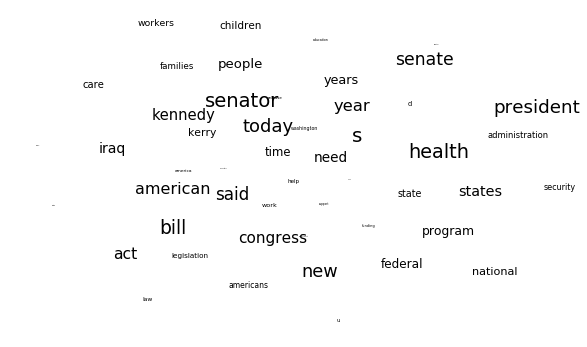

In [17]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples

In [19]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [20]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [21]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [22]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [23]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [24]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [36]:
# Loading the corpus
import os
import pandas as pd

art_chicago_info_list = []
filename_list = []
repo = '/Users/lucient/Desktop/museum_project/museum'

for filename in os.listdir(repo): 
    if 'artwork_description_metadata' in filename and not filename.startswith('.'): 
        filename_list.append(filename)
        art_chicago_info_list.append(pd.read_csv(repo + '/' + filename, index_col=False))

art_chicago = pd.concat(art_chicago_info_list)

In [37]:
inds_list = []
for inds in [(file.split('_')[4], file.split('_')[5].split('.')[0]) for file in filename_list]: 
    for ind in inds: 
        if len(ind) == 4: 
            inds_list.append(ind)
        elif len(ind) < 4: 
            inds_list.append('0'*(4-len(ind)) + ind)
        else: 
            print('Wrong')
print(f'The corpus contains {sorted(inds_list)[-1]}/9999 artwork displayed on the website of the Art Institute of Chicago')

The corpus contains 9500/9999 artwork displayed on the website of the Art Institute of Chicago


In [38]:
art_chicago.reset_index(inplace=True)
art_chicago.drop(axis=1, labels=['level_0'], inplace=True)
art_chicago.head()

artwork_title  \
0         “A” and the Carpenter I, 1973, Sam Gilliam   
1           The Baptism of Christ, 1500/05, Perugino   
2  Lovers Surprised by Death, 1510, Hans Burgkmai...   
3            Calla Lilies, 1922/25, Arthur B. Carles   
4                        Figure, 1927, Pablo Picasso   

                                    description_text   index  \
0  In the early 1960s Sam Gilliam began to experi...  1852.0   
1  Perugino’s serene and decorous art was widely ...  1854.0   
2  Themes derived from the Dance of Death, a medi...  1858.0   
3  In 1922, Arthur B. Carles began a series of ca...  1860.0   
4  Head is an example of Pablo Picasso’s constant...  1863.0   

                                            metadata  \
0  Artist\nSam Gilliam\nTitle\n"A" and the Carpen...   
1  Artist\nPerugino\nTitle\nThe Baptism of Christ...   
2  Artist\nHans Burgkmair, the elder\nTitle\nLove...   
3  Artist\nArthur B. Carles\nTitle\nCalla Lilies\...   
4  Artist\nPablo Picasso\nTitle\nFigure\nOrigin\n...   

                                                 url  
0  https://www.artic.edu/artworks/45860/a-and-the...  
1  https://www.artic.edu/artworks/16197/the-bapti...  
2  https://www.artic.edu/artworks/147064/lovers-s...  
3  https://www.artic.edu/artworks/193869/calla-li...  
4        https://www.artic.edu/artworks/75315/figure

In [39]:
# Apply functions to tokenize and normalize the text but not to lemmatize. 
# First, tokenize
art_chicago['tokenized_sents'] = art_chicago['description_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])

In [40]:
# Second, normalize
art_chicago['normalized_sents'] = art_chicago['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

In [41]:
art_chicago.head()

artwork_title  \
0         “A” and the Carpenter I, 1973, Sam Gilliam   
1           The Baptism of Christ, 1500/05, Perugino   
2  Lovers Surprised by Death, 1510, Hans Burgkmai...   
3            Calla Lilies, 1922/25, Arthur B. Carles   
4                        Figure, 1927, Pablo Picasso   

                                    description_text   index  \
0  In the early 1960s Sam Gilliam began to experi...  1852.0   
1  Perugino’s serene and decorous art was widely ...  1854.0   
2  Themes derived from the Dance of Death, a medi...  1858.0   
3  In 1922, Arthur B. Carles began a series of ca...  1860.0   
4  Head is an example of Pablo Picasso’s constant...  1863.0   

                                            metadata  \
0  Artist\nSam Gilliam\nTitle\n"A" and the Carpen...   
1  Artist\nPerugino\nTitle\nThe Baptism of Christ...   
2  Artist\nHans Burgkmair, the elder\nTitle\nLove...   
3  Artist\nArthur B. Carles\nTitle\nCalla Lilies\...   
4  Artist\nPablo Picasso\nTitle\nFigure\nOrigin\n...   

                                                 url  \
0  https://www.artic.edu/artworks/45860/a-and-the...   
1  https://www.artic.edu/artworks/16197/the-bapti...   
2  https://www.artic.edu/artworks/147064/lovers-s...   
3  https://www.artic.edu/artworks/193869/calla-li...   
4        https://www.artic.edu/artworks/75315/figure   

                                     tokenized_sents  \
0  [[In, the, early, 1960s, Sam, Gilliam, began, ...   
1  [[Perugino, ’s, serene, and, decorous, art, wa...   
2  [[Themes, derived, from, the, Dance, of, Death...   
3  [[In, 1922, Arthur, B., Carles, began, a, seri...   
4  [[Head, is, an, example, of, Pablo, Picasso, ’...   

                                    normalized_sents  
0  [[early, 1960s, sam, gilliam, began, experimen...  
1  [[perugino, serene, decorous, art, widely, inf...  
2  [[themes, derived, dance, death, medieval, all...  
3  [[arthur, b., carles, began, series, calla, li...  
4  [[head, example, pablo, picasso, constant, exp...

In [42]:
# word2vec
art_chicago_w2v = gensim.models.word2vec.Word2Vec(art_chicago['normalized_sents'].sum(), hs=1, negative=0)

In [43]:
# save the result
art_chicago_w2v.save("art_chicago_word2vec")

In [11]:
# try to find the most similar words
art_chicago_w2v.most_similar('impressionism')

[('wrote', 0.9996084570884705),
 ('country', 0.9996060729026794),
 ('described', 0.999582827091217),
 ('said', 0.9995779991149902),
 ('buildings', 0.9995752573013306),
 ('idea', 0.9995672702789307),
 ('germany', 0.9995654821395874),
 ('helped', 0.9995648264884949),
 ('film', 0.9995611906051636),
 ('continued', 0.9995599985122681)]

In [12]:
art_chicago_w2v.most_similar('religion')

[('night', 0.9997351169586182),
 ('way', 0.9997290372848511),
 ('louis', 0.9997260570526123),
 ('example', 0.9997247457504272),
 ('sculptor', 0.999721884727478),
 ('house', 0.9997193813323975),
 ('government', 0.9997190237045288),
 ('little', 0.9997171759605408),
 ('quality', 0.9997161626815796),
 ('present', 0.9997150897979736)]

In [13]:
art_chicago_w2v.most_similar('chinese')

[('associated', 0.9999223351478577),
 ('book', 0.9999046325683594),
 ('employed', 0.999903678894043),
 ('special', 0.9999030828475952),
 ('spanish', 0.999902069568634),
 ('cultural', 0.9999013543128967),
 ('particularly', 0.9999005794525146),
 ('narrative', 0.9999005794525146),
 ('imagery', 0.9998995065689087),
 ('iron', 0.9998992681503296)]

In [14]:
art_chicago_w2v.most_similar('american')

[('exhibited', 0.9993907809257507),
 ('pp', 0.9992698431015015),
 ('exhibition', 0.9991814494132996),
 ('modern', 0.9988856315612793),
 ('exhibitions', 0.9988381862640381),
 ('pop', 0.9988373517990112),
 ('acquired', 0.9988210797309875),
 ('dealer', 0.9986977577209473),
 ('hermitage', 0.998285710811615),
 ('galleries', 0.9981751441955566)]

In [15]:
art_chicago_w2v.most_similar('cityscape')

[('replicate', 0.9854030609130859),
 ('shelf', 0.9853436350822449),
 ('shiny', 0.9852387309074402),
 ('compartments', 0.9850953221321106),
 ('fantasies', 0.9850114583969116),
 ('loosely', 0.9847899079322815),
 ('clad', 0.9847266674041748),
 ('montmartre', 0.9847018718719482),
 ('best', 0.9846711158752441),
 ('glowing', 0.9846572875976562)]

In [16]:
art_chicago_w2v.most_similar('european')

[('charles', 0.9997946619987488),
 ('robert', 0.999780535697937),
 ('leading', 0.9997775554656982),
 ('influential', 0.9997735023498535),
 ('sought', 0.9997573494911194),
 ('architecture', 0.9997571110725403),
 ('master', 0.9997538328170776),
 ('painting', 0.9997442364692688),
 ('sculpture', 0.9997418522834778),
 ('japanese', 0.9997336864471436)]

In [17]:
art_chicago_w2v.most_similar('mythology')

[('expression', 0.9997982382774353),
 ('chinese', 0.9997963905334473),
 ('executed', 0.9997951984405518),
 ('living', 0.9997949600219727),
 ('political', 0.9997938275337219),
 ('book', 0.9997930526733398),
 ('engraving', 0.9997912645339966),
 ('reflects', 0.9997910857200623),
 ('imagery', 0.9997870922088623),
 ('themes', 0.9997868537902832)]

In [18]:
art_chicago_w2v.most_similar('bauhaus')

[('joseph', 0.9995262026786804),
 ('studies', 0.9994899034500122),
 ('photographer', 0.9994614720344543),
 ('exposition', 0.9993281364440918),
 ('works', 0.999281644821167),
 ('washington', 0.9992699027061462),
 ('pop', 0.9991809725761414),
 ('director', 0.9991735816001892),
 ('photography', 0.9991657733917236),
 ('national', 0.9991642832756042)]

In [19]:
art_chicago_w2v.most_similar('modernity')

[('europe', 0.9990852475166321),
 ('second', 0.9990513920783997),
 ('gris', 0.999008059501648),
 ('turn', 0.9990039467811584),
 ('tradition', 0.9989744424819946),
 ('traveled', 0.998956024646759),
 ('italian', 0.9989362359046936),
 ('italy', 0.9989266395568848),
 ('poet', 0.9989265203475952),
 ('community', 0.9989208579063416)]

In [20]:
art_chicago_w2v.most_similar('neoclassical')

[('living', 0.9996522665023804),
 ('led', 0.9996402263641357),
 ('region', 0.9996373653411865),
 ('northern', 0.9996270537376404),
 ('rome', 0.9996252059936523),
 ('visual', 0.9996189475059509),
 ('trip', 0.9996179342269897),
 ('today', 0.999611496925354),
 ('model', 0.9996077418327332),
 ('people', 0.9996010065078735)]

In [21]:
art_chicago_w2v.most_similar('democratic')

[('find', 0.9994916915893555),
 ('tradition', 0.9994786381721497),
 ('given', 0.9994767904281616),
 ('way', 0.9994730949401855),
 ('dynasty', 0.9994716644287109),
 ('day', 0.9994686841964722),
 ('pictures', 0.9994674324989319),
 ('prominent', 0.9994672536849976),
 ('sculptor', 0.9994666576385498),
 ('growing', 0.9994639754295349)]

In [22]:
art_chicago_w2v.most_similar('hue')

[('rendered', 0.999096155166626),
 ('mask', 0.9990811347961426),
 ('shapes', 0.9990731477737427),
 ('central', 0.9990695118904114),
 ('seated', 0.9990434646606445),
 ('use', 0.9990421533584595),
 ('male', 0.9990369081497192),
 ('interior', 0.9990342259407043),
 ('different', 0.9990233778953552),
 ('glass', 0.999011754989624)]

In [23]:
art_chicago_w2v.wv.most_similar('woman', topn=20)

[('depicted', 0.9998801946640015),
 ('seated', 0.9998399019241333),
 ('man', 0.999817430973053),
 ('body', 0.9998100996017456),
 ('christ', 0.9998087286949158),
 ('brown', 0.9998079538345337),
 ('composition', 0.9998031258583069),
 ('dark', 0.9998029470443726),
 ('human', 0.9997955560684204),
 ('background', 0.9997930526733398),
 ('paint', 0.9997879266738892),
 ('scenes', 0.9997859597206116),
 ('foreground', 0.9997824430465698),
 ('colors', 0.9997799396514893),
 ('bright', 0.9997767210006714),
 ('washes', 0.9997705221176147),
 ('contrast', 0.9997629523277283),
 ('water', 0.9997624754905701),
 ('large', 0.9997619390487671),
 ('palette', 0.9997472167015076)]

'man' and 'woman' are not discriminated in artworks 

In [24]:
art_chicago_w2v.wv.most_similar(positive=['french', 'american'], negative=['impressionism'], topn=10)

[('exhibited', 0.9989447593688965),
 ('modern', 0.9987978935241699),
 ('exhibitions', 0.9984970092773438),
 ('dealer', 0.9984408617019653),
 ('pp', 0.9983413815498352),
 ('hermitage', 0.997882068157196),
 ('exhibition', 0.9978694915771484),
 ('surrealist', 0.9978305101394653),
 ('acquired', 0.9977937936782837),
 ('pop', 0.9975965023040771)]

'impressionism' to 'french' is like 'modern' or 'surrealist' to 'america'. 

In [25]:
art_chicago_w2v.wv.most_similar(positive=['canvas', 'sculpture'], negative=['painting'], topn=20)

[('viewer', 0.9996849298477173),
 ('visible', 0.9996744990348816),
 ('child', 0.9996660947799683),
 ('features', 0.9996638298034668),
 ('gold', 0.9996615648269653),
 ('bird', 0.9996557235717773),
 ('frame', 0.999646782875061),
 ('reveal', 0.9996464252471924),
 ('shaped', 0.9996424317359924),
 ('wood', 0.9996421337127686),
 ('effect', 0.9996412992477417),
 ('ground', 0.9996380805969238),
 ('applied', 0.9996343851089478),
 ('brush', 0.9996283054351807),
 ('fish', 0.9996242523193359),
 ('mouth', 0.9996235966682434),
 ('sense', 0.9996224045753479),
 ('away', 0.9996178150177002),
 ('feet', 0.9996172785758972),
 ('silver', 0.9996129274368286)]

'Canvas' to 'painting' is like 'wood' to 'sculpture'. 

In [26]:
art_chicago_w2v.wv.most_similar(positive=['red', 'white'], negative=['black'], topn=20)

[('blue', 0.9992197155952454),
 ('color', 0.9991461634635925),
 ('light', 0.9989545345306396),
 ('left', 0.9988061189651489),
 ('head', 0.9986767768859863),
 ('figure', 0.9986107349395752),
 ('figures', 0.9985578060150146),
 ('yellow', 0.9984493851661682),
 ('upper', 0.9983021020889282),
 ('gray', 0.9982590079307556),
 ('surface', 0.9982578754425049),
 ('hand', 0.9981964826583862),
 ('female', 0.9981964230537415),
 ('right', 0.9980833530426025),
 ('colors', 0.998003363609314),
 ('composition', 0.9979501962661743),
 ('dark', 0.997830331325531),
 ('passion', 0.9977579116821289),
 ('brown', 0.9977517127990723),
 ('large', 0.9977059960365295)]

'black' to 'white' is like 'blue' to 'red' 

In [27]:
# Try to find words that characterize 'expressionism' just like 'colors' is a feature of 'impressionism'
art_chicago_w2v.wv.most_similar(positive=['colors', 'expressionism'], negative=['impressionism'], topn=60)

[('composition', 0.9989560842514038),
 ('surface', 0.9989368915557861),
 ('yellow', 0.9988983869552612),
 ('dark', 0.9988893270492554),
 ('female', 0.9988782405853271),
 ('paint', 0.9988671541213989),
 ('body', 0.9988610744476318),
 ('figures', 0.9988585710525513),
 ('texture', 0.9988567233085632),
 ('depicted', 0.9988479614257812),
 ('gray', 0.9988456964492798),
 ('human', 0.9988429546356201),
 ('background', 0.9988361597061157),
 ('upper', 0.9988347887992859),
 ('large', 0.9988325834274292),
 ('seated', 0.9988250732421875),
 ('brown', 0.9988242983818054),
 ('green', 0.9988042116165161),
 ('woman', 0.9987931251525879),
 ('pigment', 0.9987813234329224),
 ('lower', 0.9987776279449463),
 ('christ', 0.9987698793411255),
 ('scenes', 0.9987683296203613),
 ('water', 0.9987630844116211),
 ('small', 0.9987595081329346),
 ('bright', 0.998754620552063),
 ('palette', 0.9987441301345825),
 ('stands', 0.9987301826477051),
 ('passion', 0.99872887134552),
 ('figure', 0.9987226724624634),
 ('paper', 0

In [28]:
# reduce dimension to visualize

# using PCA
pcaWords = sklearn.decomposition.PCA(n_components = 2).fit(art_chicago_w2v.wv.syn0)
reducedPCA_data = pcaWords.transform(art_chicago_w2v.wv.syn0)

In [29]:
# using T-SNE 
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(art_chicago_w2v.wv.syn0)

In [30]:
targetWords = art_chicago_w2v.wv.index2word[:]
numWords = len(targetWords)
numWords

7207

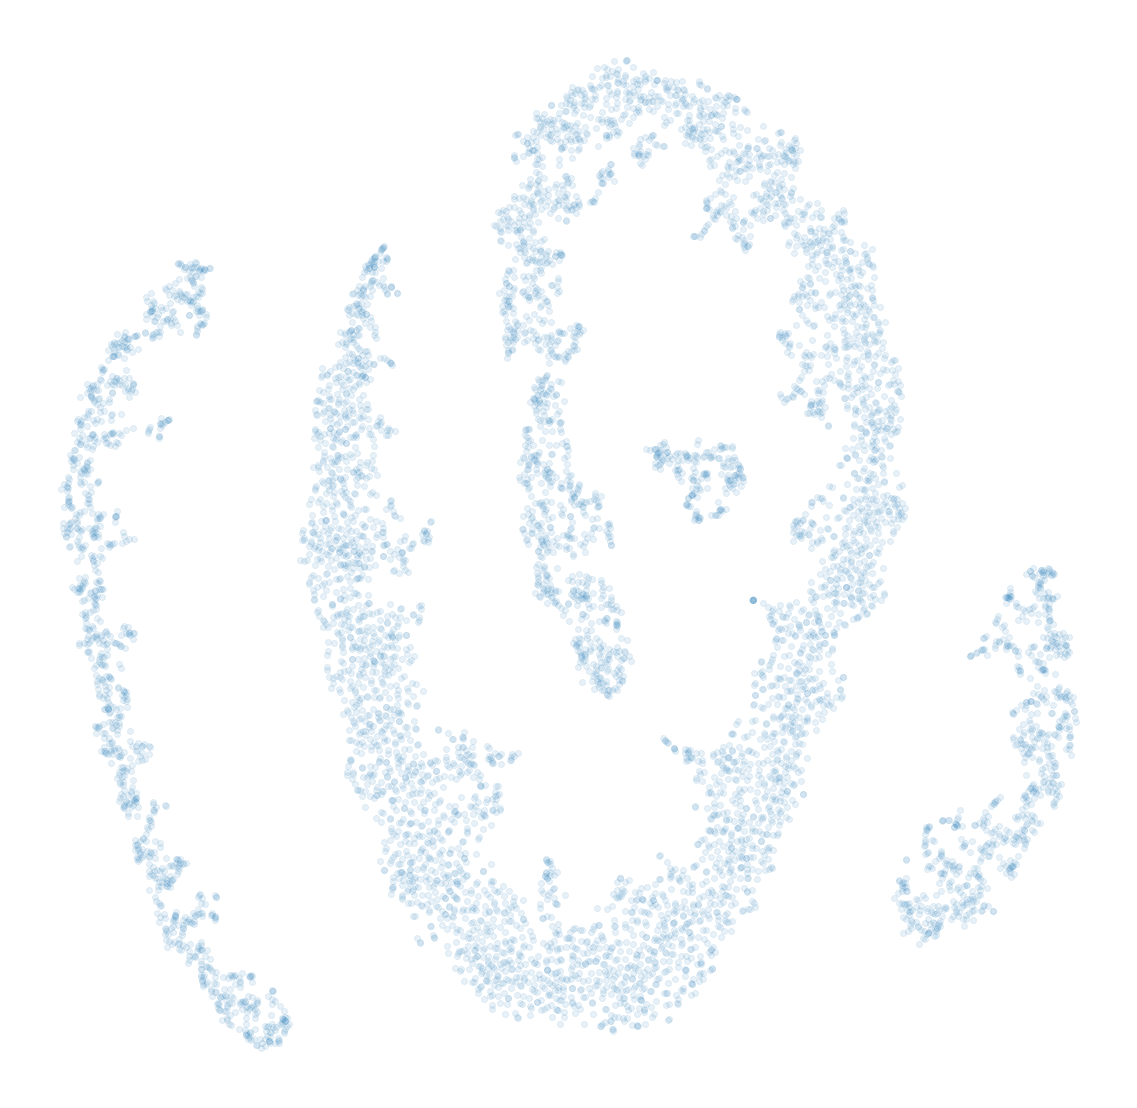

In [31]:
# Plot the result of TSNE
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0.1)#Making the points invisible 
# for i, word in enumerate(targetWords):
#     ax.annotate(word, (reducedPCA_data[:, 0][i], reducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

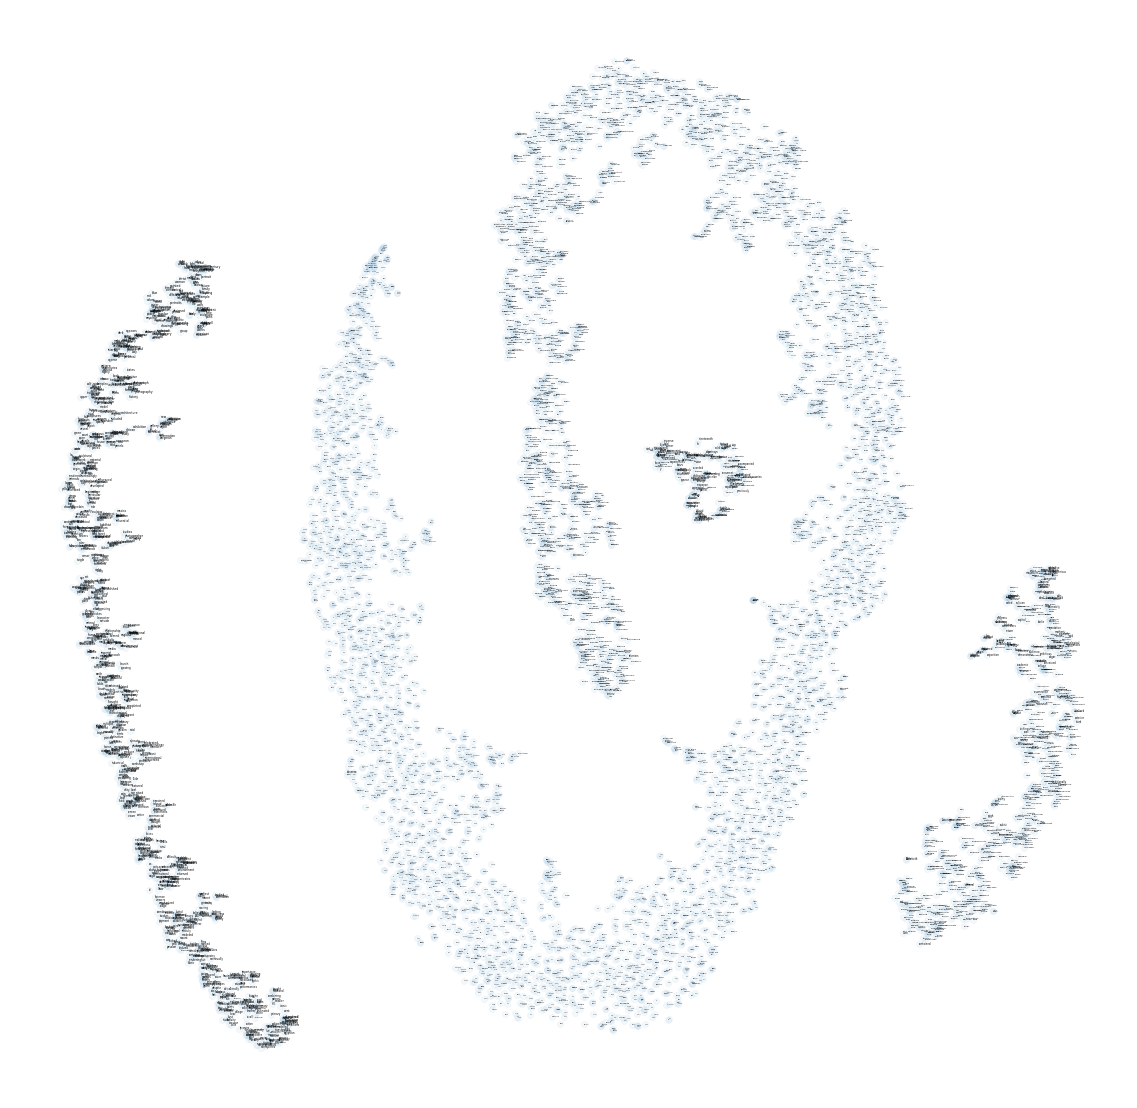

In [32]:
# Plot the result of TSNE
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0.05)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i], tsneWords[:, 1][i]), size =  3 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

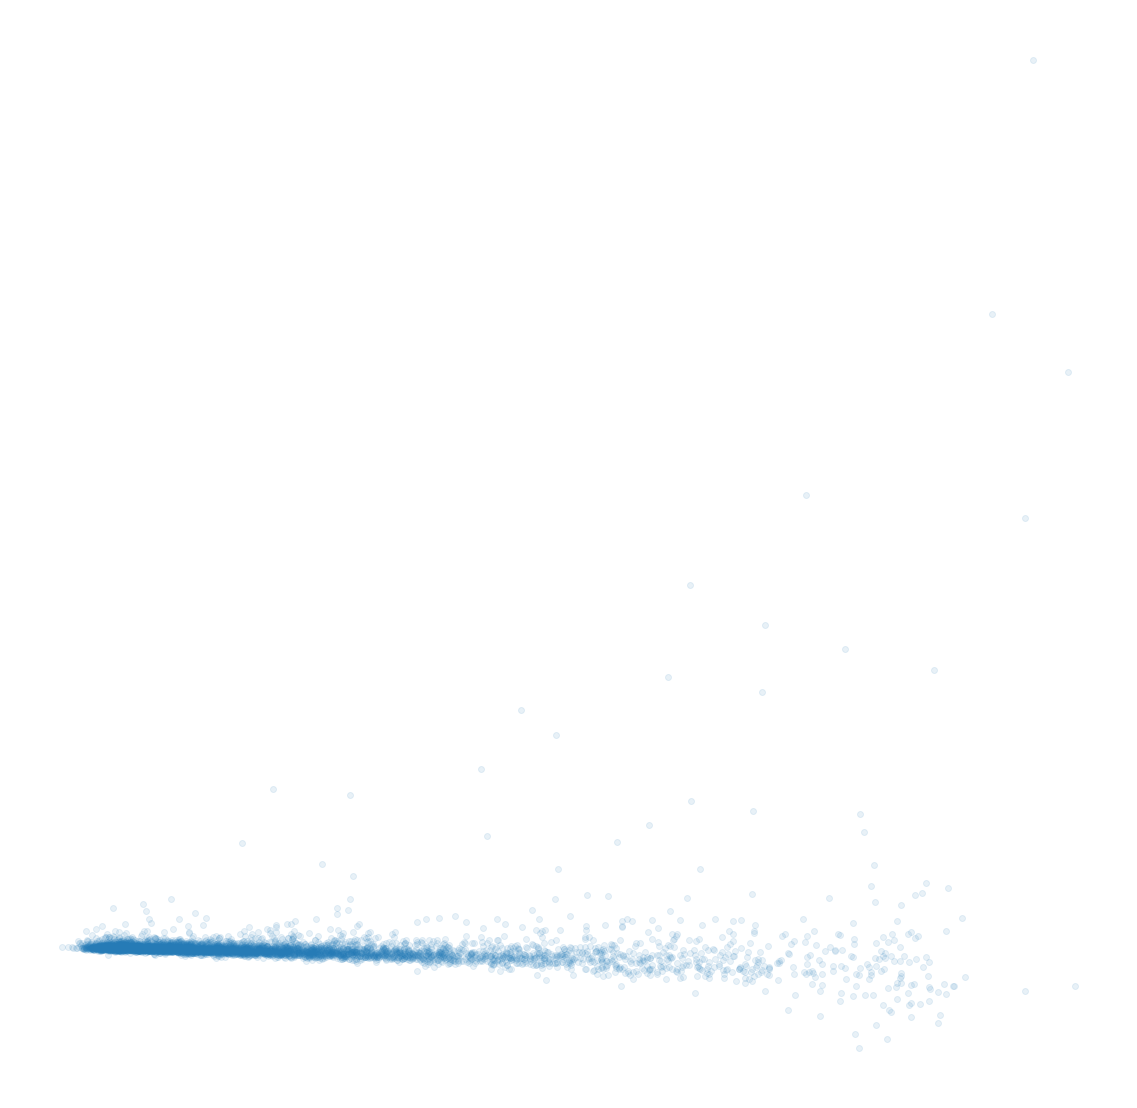

In [33]:
# Plot the result of PCA
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0.1)#Making the points invisible 
# for i, word in enumerate(targetWords):
#     ax.annotate(word, (reducedPCA_data[:, 0][i], reducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

In [34]:
# Visualize the 200-500 words
start = 200
numWords = 300
targetWords = art_chicago_w2v.wv.index2word[start: start + numWords]


wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(art_chicago_w2v[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.01116024,  0.42035466, -0.16996747, ...,  0.00787474,
        -0.2884567 , -1.2254943 ],
       [-0.0363516 ,  0.4685634 , -0.17655909, ...,  0.01325886,
        -0.29149422, -1.2790114 ],
       [-0.02249356,  0.46038404, -0.1857434 , ...,  0.01136291,
        -0.30204228, -1.2912816 ],
       ...,
       [-0.02314975,  0.3441562 , -0.14227058, ...,  0.0050523 ,
        -0.20913033, -0.9503991 ],
       [-0.01585998,  0.35414103, -0.15132503, ...,  0.01262049,
        -0.24125944, -1.0201942 ],
       [-0.01707543,  0.30661014, -0.12514444, ...,  0.00393409,
        -0.2082095 , -0.8808367 ]], dtype=float32)

In [35]:
# reduce dimension to visualize

# using PCA
pcaWords = sklearn.decomposition.PCA(n_components = 2).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)

# using TSNE
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(wordsSubMatrix)

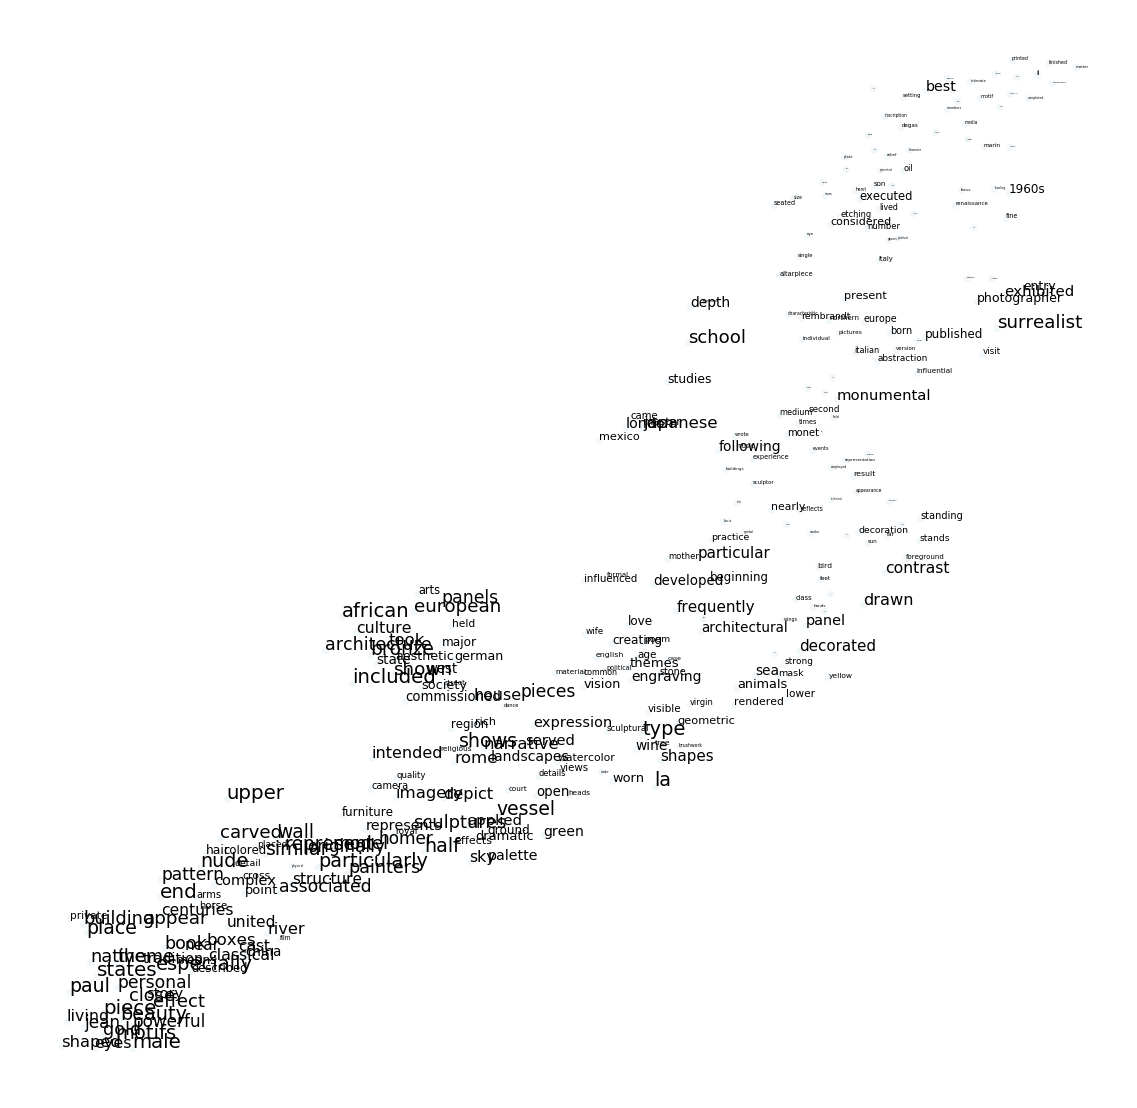

In [36]:
# Plot the result of TSNE
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0.05)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i], tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

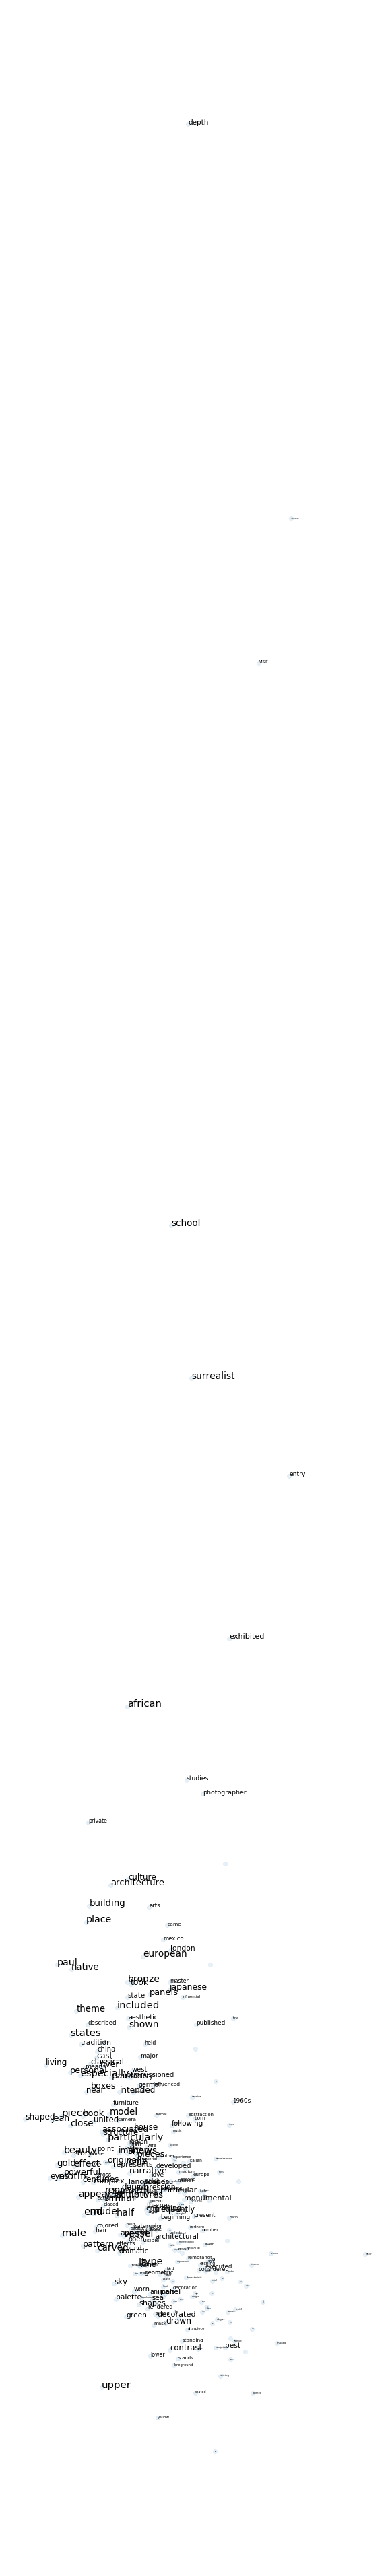

In [37]:
# Plot the result of PCA
fig = plt.figure(figsize = (10,70))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0.1)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data[:, 0][i], reducedPCA_data[:, 1][i]), size =  15 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()


The word embedding space can reveal certain patterns underlying the characteristics of the artworks collected in the Art Institute of Chicago. For examples, some features are significant to describe certain art styles: impressionists pay significant attentions to incorporating colors in their artworks, words like 'geometric', 'line', 'patterns' are revealed using vector operations for 'expressionism'. Another example is that the original geographical sources of the art styles may be revealed as well: 'impressionism' to 'frech' is as if 'modernity' or 'surrealism' to 'york' (New York), which is consistent with the art history. 

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [25]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

copyrightYear                        doi  \
0           1950  10.1103/RevModPhys.22.221   
1           1951  10.1103/RevModPhys.23.147   
2           1951  10.1103/RevModPhys.23.185   
3           1951  10.1103/RevModPhys.23.203   
4           1951   10.1103/RevModPhys.23.21   
5           1951  10.1103/RevModPhys.23.311   
6           1951  10.1103/RevModPhys.23.315   
7           1951  10.1103/RevModPhys.23.322   
8           1951  10.1103/RevModPhys.23.328   
9           1952  10.1103/RevModPhys.24.108   

                                            abstract  
0  A summarizing account is given of the research...  
1  New tables of coulomb functions are presented ...  
2  Ionization by electron impact in diatomic gase...  
3  It is shown that the conductivity in the ohmic...  
4  The factorization method is an operational pro...  
5  A brief account is given of Dyson's proof of t...  
6  A systematics is given of all transitions for ...  
7  A systematics of the -transitions of even A nu...  
8  The available experiments on the absorption sp...  
9  The classical theory of the dynamics of viscou...

We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [26]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [27]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [28]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [29]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [30]:
apsD2V.docvecs[1952]

array([ 0.19856402, -0.32607275, -0.5434297 ,  1.1079134 , -0.7955435 ,
        0.99836284,  0.02586303, -0.77402437,  0.74257386,  1.140868  ,
       -2.4344554 , -0.13921498, -1.2160647 , -1.4391065 , -0.63838714,
        2.1025863 , -0.12144856, -1.331758  ,  0.01048518, -0.6495456 ,
        1.7060442 ,  0.18673746, -0.35625997, -0.8610773 , -0.86390185,
        1.0696704 , -0.23027356,  0.04415682,  0.92669034, -0.50605357,
       -1.2538182 , -0.8345244 ,  1.09148   , -0.9151546 , -1.3085489 ,
       -1.5950308 , -0.54413456,  2.0067692 ,  0.04618606,  1.4554724 ,
        1.4843128 ,  1.5505302 , -1.2077212 , -0.2808706 ,  1.2828134 ,
        0.9156761 , -0.69469404, -0.44501895, -0.50577635,  0.54679835,
       -0.43360424, -0.2895272 , -1.8368219 ,  0.46414116,  0.60980177,
       -0.03472868,  0.7123255 , -0.79734975,  1.5043598 ,  0.6873778 ,
        1.3033248 , -0.2133346 ,  0.22569688, -1.3537297 ,  0.7381637 ,
       -0.10078208, -1.7898892 , -0.2197677 , -0.65157926, -0.50

The words can still be accessed in the same way:

In [31]:
apsD2V['atom']

array([ 0.18284628, -0.04895942, -0.89525455,  0.386619  ,  0.15722378,
        0.28620473,  0.34100235,  0.6834194 , -0.00408947,  0.6566478 ,
       -0.5354382 ,  0.01004452,  0.43740138, -1.091602  ,  0.22807835,
        0.71692365, -0.37653923, -0.10362295, -0.16604191,  0.3131635 ,
       -0.35241136, -0.8172237 ,  0.3936495 , -0.5299927 ,  0.13411738,
        0.2986211 , -0.45632944,  0.00526831,  0.7483204 , -0.34703842,
       -0.8986433 , -0.25062317,  0.16325492, -1.1789956 ,  0.1183672 ,
        0.30810228, -1.107009  ,  0.42208552,  0.41748974,  0.7264739 ,
        0.8722728 ,  1.4183432 , -0.25191745,  0.8265018 ,  0.19808555,
        0.23069115, -0.17685364, -0.29582533,  0.05870611,  0.10616075,
       -0.45562714,  0.17342158, -0.25422886,  0.7015164 ,  0.7497404 ,
       -0.07426755,  1.2640078 , -0.19158858, -0.70047724,  0.10496335,
       -0.91657907, -0.8523482 ,  0.6237608 , -0.09004818,  0.08607046,
       -0.2238795 ,  0.4310083 , -0.21755084, -1.1692094 , -0.53

We can still use the ``most_similar`` command to perform simple semantic equations:

In [32]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.808495819568634)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [33]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('resemblance', 0.9027340412139893)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [34]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.63588536]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [35]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.113.479', 0.6609346866607666),
 ('10.1103/PhysRev.104.1528', 0.6466891169548035),
 ('10.1103/PhysRev.110.857', 0.6089353561401367),
 ('10.1103/PhysRev.106.191', 0.6088852882385254),
 ('10.1103/PhysRev.100.1646', 0.6056019067764282)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

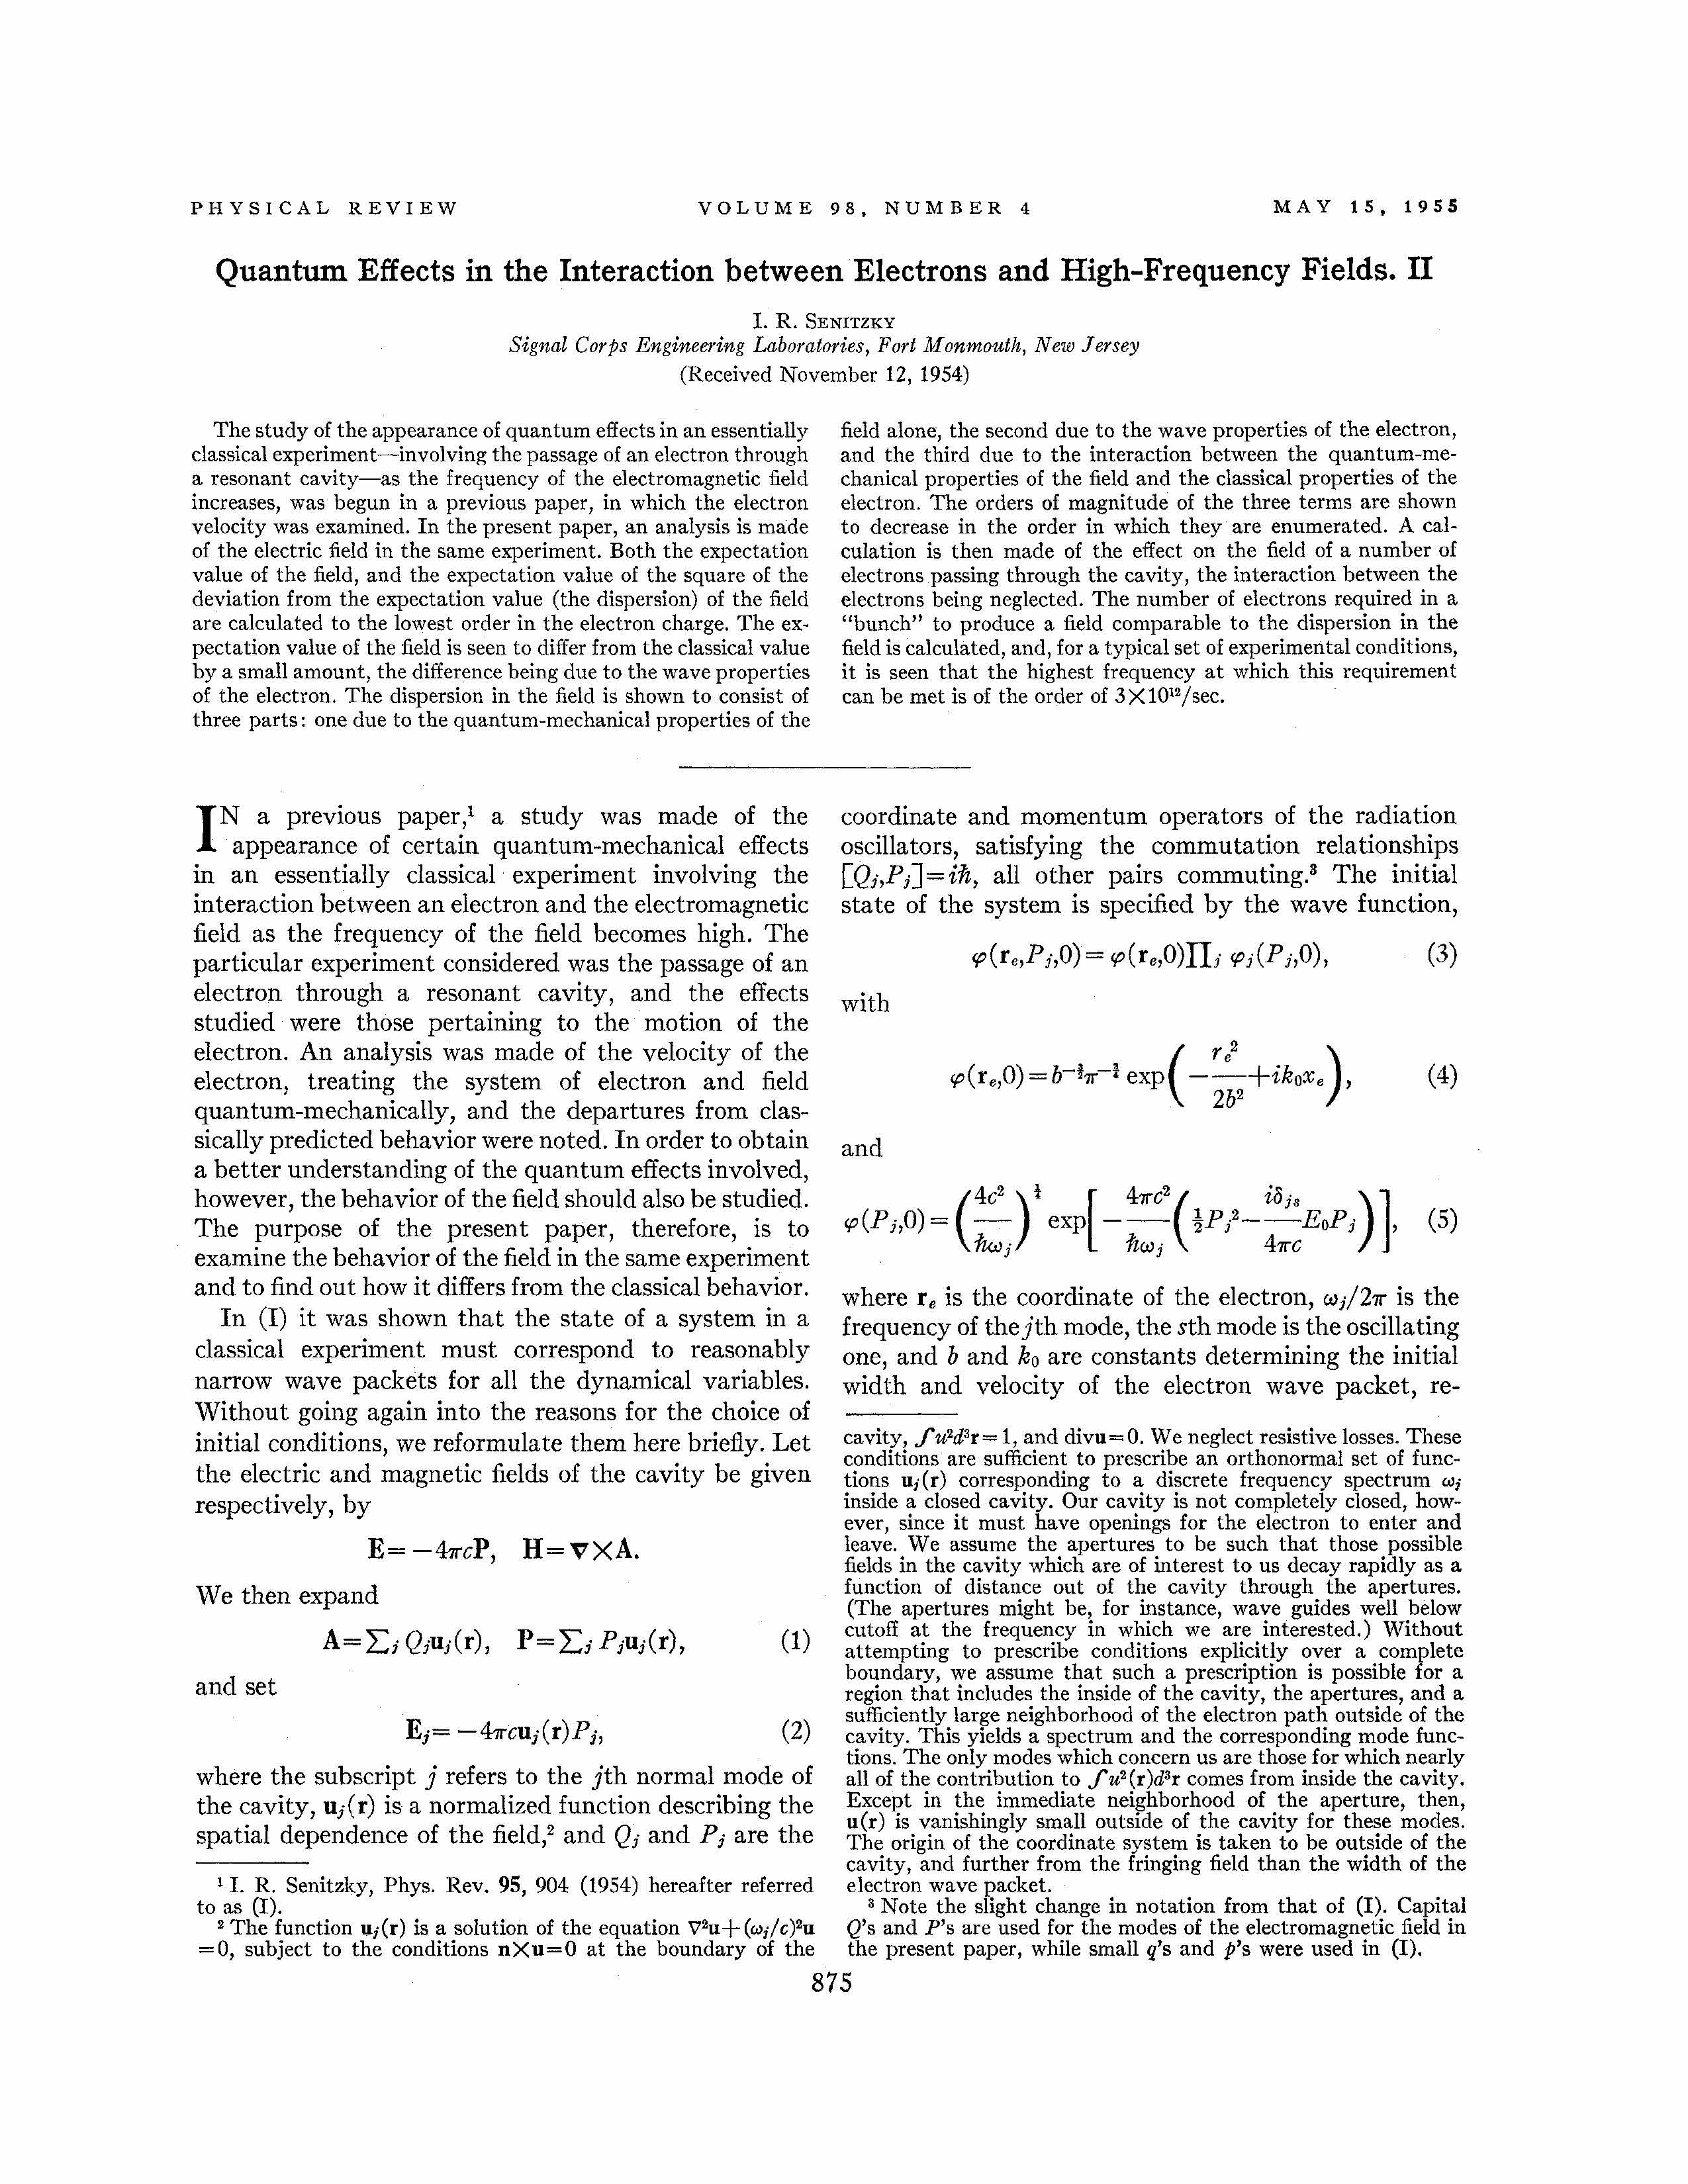

In [36]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [37]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('volts', 0.8236003518104553),
 ('attaining', 0.8067859411239624),
 ('shielding', 0.7597390413284302),
 ('kv', 0.7478094100952148),
 ('vary', 0.7477940917015076)]

We can even look for documents most like a query composed of multiple words:

In [38]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.85.1012', 0.7578761577606201),
 ('10.1103/PhysRev.89.631', 0.7375411987304688),
 ('10.1103/PhysRev.108.570', 0.7350585460662842),
 ('10.1103/PhysRev.116.1583', 0.7231032848358154),
 ('10.1103/PhysRev.92.1218', 0.7129611968994141)]

Now let's plot some words and documents against one another with a heatmap:

In [39]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

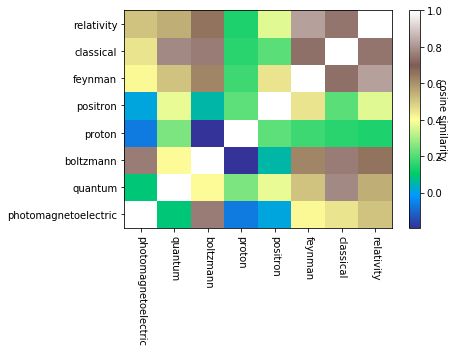

In [40]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [41]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

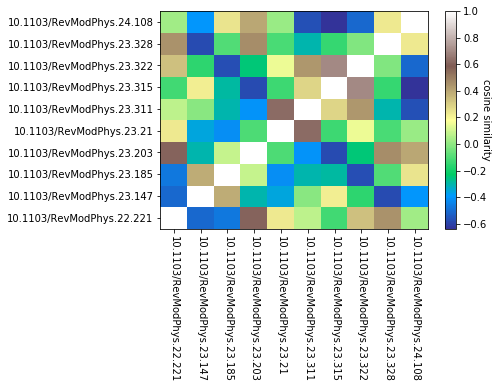

In [42]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [43]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

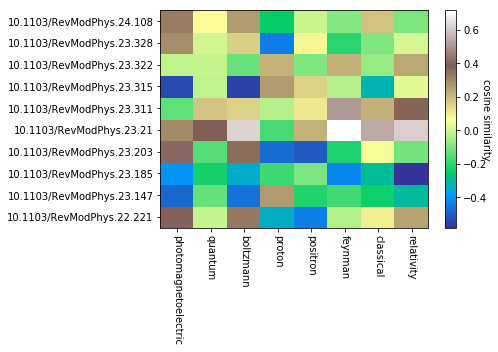

In [44]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [45]:
apsD2V.save('apsW2V')

We can later load it:

In [46]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [38]:
# merge the texts by artist
art_chicago['metadata_split'] = [meta.split('\n') for meta in art_chicago['metadata']]
art_chicago['metadata_split'].head(3)

0    [Artist, Abraham Bosse, Title, The Engraver an...
1    [Artist, Katsushika Hokusai, Title, Sojo Henjo...
2    [Artist, Karl Wirsum, Title, Youdue, Origin, U...
Name: metadata_split, dtype: object

In [39]:
artists = []
for index, row in art_chicago.iterrows(): 
    if 'Artist' in row['metadata_split']: 
        position = row['metadata_split'].index('Artist') + 1
        artists.append(row['metadata_split'][position])
    else: 
        artists.append('')
art_chicago['artist'] = artists

In [40]:
# merge multiple paragraphs by artist_name
# then we can perform doc2vec by taking the all the text associated with one artist as a document

artists_list = set(art_chicago['artist'])
art_chicago_merge_by_artist_dict = dict()
for row_index, row in art_chicago.iterrows(): 
    if row['artist'] in art_chicago_merge_by_artist_dict:
        art_chicago_merge_by_artist_dict[row['artist']] += row['description_text']
    else: 
        art_chicago_merge_by_artist_dict[row['artist']] = row['description_text']

art_chicago_artists = pandas.DataFrame(data=art_chicago_merge_by_artist_dict, index=['description']).transpose()

In [41]:
art_chicago_artists.drop('', axis=0, inplace=True)
art_chicago_artists.dropna(inplace=True)
art_chicago_artists.shape

(1099, 1)

In [42]:
art_chicago_artists.head()

description
Abraham Bosse        Abraham Bosse wrote the first important treati...
Katsushika Hokusai   This is a scene based on the poet’s early care...
Karl Wirsum          A 1961 graduate of SAIC, Wirsum was influenced...
Richard Diebenkorn   Richard Diebenkorn’s first serious effort at p...
Henri Fantin-Latour  Richard Wagner’s opera Tannhaüser was first in...

In [43]:
# tokenize and normalize
art_chicago_artists['tokenized_words'] = art_chicago_artists['description'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
art_chicago_artists['normalized_words'] = art_chicago_artists['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [44]:
art_chicago_artists.head()

description  \
Abraham Bosse        Abraham Bosse wrote the first important treati...   
Katsushika Hokusai   This is a scene based on the poet’s early care...   
Karl Wirsum          A 1961 graduate of SAIC, Wirsum was influenced...   
Richard Diebenkorn   Richard Diebenkorn’s first serious effort at p...   
Henri Fantin-Latour  Richard Wagner’s opera Tannhaüser was first in...   

                                                       tokenized_words  \
Abraham Bosse        [Abraham, Bosse, wrote, the, first, important,...   
Katsushika Hokusai   [This, is, a, scene, based, on, the, poet, ’s,...   
Karl Wirsum          [A, 1961, graduate, of, SAIC, Wirsum, was, inf...   
Richard Diebenkorn   [Richard, Diebenkorn, ’s, first, serious, effo...   
Henri Fantin-Latour  [Richard, Wagner, ’s, opera, Tannhaüser, was, ...   

                                                      normalized_words  
Abraham Bosse        [abraham, bosse, wrote, important, treatise, a...  
Katsushika Hokusai   [scene, based, poet, early, career, descendant...  
Karl Wirsum          [graduate, saic, wirsum, influenced, art, pica...  
Richard Diebenkorn   [richard, diebenkorn, effort, printmaking, cam...  
Henri Fantin-Latour  [richard, wagner, opera, tannhaüser, interpret...

In [45]:
# tag the desciptions by the artist name
taggedDocs = []
for index, row in art_chicago_artists.iterrows():
    docKeywords = [index]
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
art_chicago_artists['TaggedDescriptions'] = taggedDocs

In [46]:
art_chicago_artists['TaggedDescriptions'][0]

LabeledSentence(words=['abraham', 'bosse', 'wrote', 'important', 'treatise', 'art', 'etching', 'highly', 'influential', 'publication', 'urged', 'etchers', 'aspire', 'precision', 'engravers', 'cultivating', 'peculiarities', 'etched', 'line', 'like', 'rembrandt', 'achieve', 'swelling', 'line', 'akin', 'engraving', 'bosse', 'utilized', 'instrument', 'called', 'échoppe', 'beveled', 'etching', 'needle', 'twist', 'ground', 'create', 'variable', 'widths', 'etched', 'line', 'similar', 'work', 'jacques', 'callot', 'print', 'etcher', 'working', 'easily', 'left', 'engraver', 'struggling', 'incise', 'plate', 'right'], tags=['Abraham Bosse'])

In [47]:
# implement doc2vec
art_chicago_artists_d2v = gensim.models.doc2vec.Doc2Vec(art_chicago_artists['TaggedDescriptions'])

In [48]:
art_chicago_artists_d2v.wv.most_similar(positive=['french', 'expressionism'], negative=['impressionism'], topn=10)

[('project', 0.9994511604309082),
 ('expressionist', 0.9994479417800903),
 ('aesthetic', 0.9994232654571533),
 ('projects', 0.9994229078292847),
 ('movement', 0.9994194507598877),
 ('approach', 0.9994182586669922),
 ('cast', 0.9994145631790161),
 ('decorative', 0.9994139671325684),
 ('called', 0.9994093775749207),
 ('video', 0.9994040131568909)]

"German" is the origin of "expressionism" while "impressionism" originates from "french". 

According to Wikipedia, expressionism is a modernist movement, initially in poetry and painting, originating in Germany at the beginning of the 20th century. Impressionism originated with a group of Paris-based artists whose independent exhibitions brought them to prominence during the 1870s and 1880s.

In [49]:
art_chicago_artists_d2v.wv.most_similar(positive=['tradition', 'unorthodox'], negative=['convention'], topn=10)

[('designed', 0.9988054037094116),
 ('renaissance', 0.998788595199585),
 ('played', 0.9987847208976746),
 ('real', 0.9987730979919434),
 ('photographed', 0.9987693428993225),
 ('similarly', 0.998759388923645),
 ('display', 0.9987553358078003),
 ('cotton', 0.9987472891807556),
 ('centuries', 0.9987345933914185),
 ('day', 0.9987319707870483)]

Good. "creative" - "tradition" dimension is parrallel to "unorthodox" - "convention" dimension. 

In [50]:
art_chicago_artists_d2v.wv.most_similar('european')

[('charles', 0.9998801350593567),
 ('african', 0.9998730421066284),
 ('trained', 0.9998655319213867),
 ('member', 0.9998569488525391),
 ('academy', 0.9998185634613037),
 ('philadelphia', 0.9998184442520142),
 ('photography', 0.9998130798339844),
 ('helped', 0.999796986579895),
 ('works', 0.9997910261154175),
 ('bronze', 0.9997712969779968)]

In [51]:
art_chicago_artists_d2v.wv.most_similar('american')

[('later', 0.9995569586753845),
 ('bauhaus', 0.9994509816169739),
 ('photographer', 0.9993689060211182),
 ('national', 0.9993286728858948),
 ('studied', 0.9993168115615845),
 ('washington', 0.9992609620094299),
 ('edward', 0.9992538690567017),
 ('influential', 0.9992498159408569),
 ('journal', 0.9992482662200928),
 ('exhibition', 0.9992374181747437)]

In [53]:
sklearn.metrics.pairwise.cosine_similarity(art_chicago_artists_d2v['american'].reshape(1,-1), 
                                           art_chicago_artists_d2v['european'].reshape(1,-1)) > \
sklearn.metrics.pairwise.cosine_similarity(art_chicago_artists_d2v['american'].reshape(1,-1), 
                                           art_chicago_artists_d2v['asian'].reshape(1,-1))

array([[ True]])

In [54]:
sklearn.metrics.pairwise.cosine_similarity(art_chicago_artists_d2v['american'].reshape(1,-1), 
                                           art_chicago_artists_d2v['european'].reshape(1,-1)) > \
sklearn.metrics.pairwise.cosine_similarity(art_chicago_artists_d2v['american'].reshape(1,-1), 
                                           art_chicago_artists_d2v['african'].reshape(1,-1))

array([[ True]])

American arts is more influenced by european arts than by asian arts or african arts. 

In [55]:
# Find artists who are the most related to 'american'
art_chicago_artists_d2v.docvecs.most_similar([art_chicago_artists_d2v['american']], topn=5 )

[('Eldzier Cortor', 0.9991196393966675),
 ('Henry Spencer Moore', 0.9990198612213135),
 ('Shigeko Kubota', 0.9988154768943787),
 ('Art Shay', 0.9987918138504028),
 ('Grant Wood', 0.9987745881080627)]

According to Wikipedia, 
- Paul Strand (October 16, 1890 – March 31, 1976) was an American photographer and filmmaker who, along with fellow modernist photographers like Alfred Stieglitz and Edward Weston, helped establish photography as an art form in the 20th century. His diverse body of work, spanning six decades, covers numerous genres and subjects throughout the Americas, Europe, and Africa.
- Art Shay (March 31, 1922 – April 28, 2018) was an American photographer and writer.
- Norman Parish (born Chicago August 26, 1937 - July 8, 2013) was an American artist and art dealer. 

In [56]:
art_chicago_artists_d2v.docvecs.most_similar([art_chicago_artists_d2v['impressionist']], topn=5 )

[('Camille Pissarro', 0.9998217225074768),
 ('Édouard Manet', 0.9998054504394531),
 ('Auguste Rodin', 0.9997991323471069),
 ('Todros Geller', 0.9997889399528503),
 ('George Inness', 0.9997870326042175)]

(Wikipedia) As a painter and muralist, Delacroix's use of expressive brushstrokes and his study of the optical effects of colour profoundly shaped the work of the __Impressionists__, while his passion for the exotic inspired the artists of the Symbolist movement. 

In [57]:
art_chicago_artists_d2v.docvecs.most_similar([art_chicago_artists_d2v['unorthodox']], topn=5 )

[('George Wesley Bellows', 0.9988783001899719),
 ('Giorgio de Chirico', 0.9988672137260437),
 ('Sam Buxton', 0.9988566040992737),
 ('David Wojnarowicz', 0.9988511800765991),
 ('Giambattista Tiepolo', 0.998843252658844)]

In [58]:
art_chicago_artists_d2v.docvecs.most_similar([art_chicago_artists_d2v['conventional']], topn=5 )

[('Giambattista Tiepolo', 0.9997532963752747),
 ('Tosa Mitsuoki', 0.9997413158416748),
 ('Todros Geller', 0.9997408390045166),
 ('Meissen Porcelain Manufactory (Manufacturer)', 0.9997360706329346),
 ('Lewis Wickes Hine', 0.9997286796569824)]

In [59]:
art_chicago_artists_d2v.docvecs.most_similar([art_chicago_artists_d2v['bauhaus']], topn=5 )

[('Eldzier Cortor', 0.9995095729827881),
 ('Henry Spencer Moore', 0.9993988275527954),
 ('Art Shay', 0.9993650913238525),
 ('Shigeko Kubota', 0.9992523193359375),
 ('Grant Wood', 0.9992250800132751)]

In [60]:
art_chicago_artists_d2v.docvecs.most_similar([art_chicago_artists_d2v['chicago']], topn=5 )

[('Alfred Stieglitz', 0.9899857044219971),
 ('Arnold Rönnebeck', 0.9831929206848145),
 ('Edward Steichen', 0.9612579345703125),
 ('Gertrude Käsebier', 0.9410587549209595),
 ('Margaret Burroughs', 0.9339705109596252)]

In [61]:
art_chicago_artists_d2v.docvecs.most_similar(positive=[art_chicago_artists_d2v['creative']], negative=[art_chicago_artists_d2v['traditional']])

[('Frank Eugene', -0.12366967648267746),
 ('Arnold Rönnebeck', -0.8138615489006042),
 ('Alfred Stieglitz', -0.8217559456825256),
 ('Margaret Burroughs', -0.8981207013130188),
 ('Edward Steichen', -0.9032161235809326),
 ('Georg Fennitzer', -0.9082590937614441),
 ('Joseph Cornell', -0.9244540929794312),
 ('Gertrude Käsebier', -0.9290238618850708),
 ('Jean Jacques de Boissieu', -0.9431201219558716),
 ('Pieter Bruegel, the elder', -0.9464369416236877)]

In [62]:
# Find the most similar artists to van Gogh
art_chicago_artists_d2v.docvecs.most_similar( [ art_chicago_artists_d2v.docvecs['Vincent van Gogh'] ], topn=5) 

[('Vincent van Gogh', 1.0),
 ('Bruce Nauman', 0.999885082244873),
 ('Georges Braque', 0.9998558163642883),
 ('Doug Aitken', 0.999848484992981),
 ('Henri Matisse', 0.9998453855514526)]

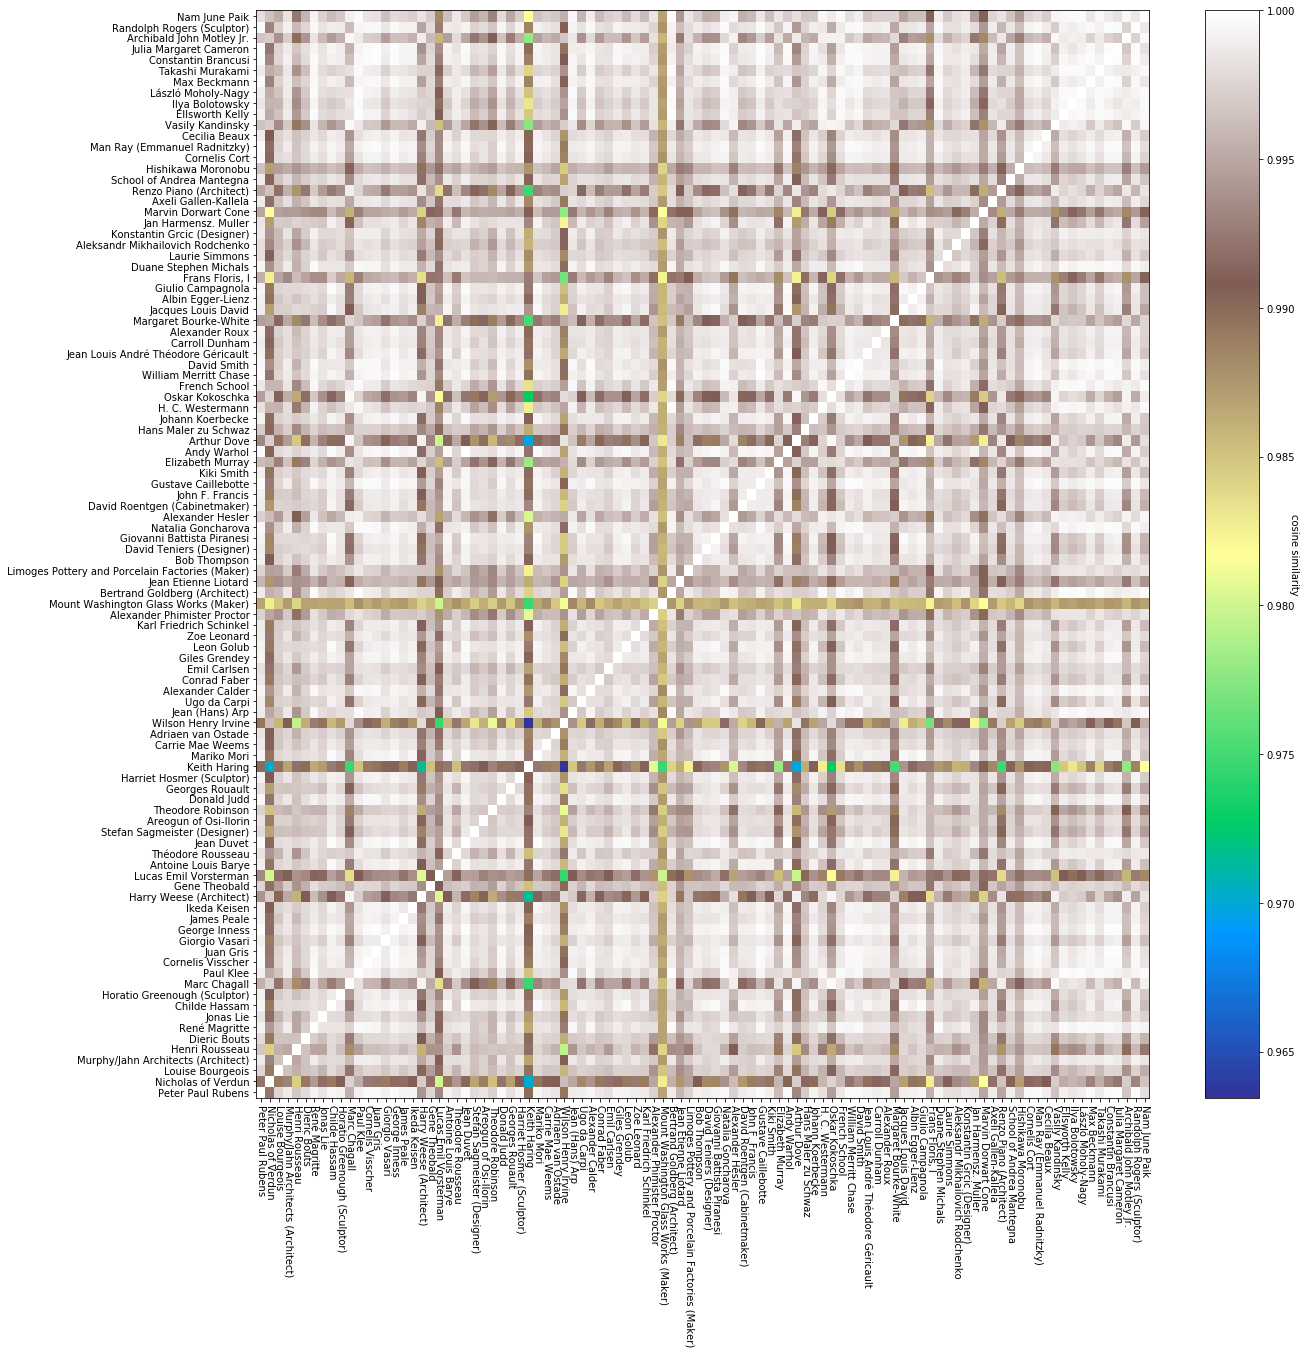

In [63]:
# Visualize similarities between artists

targetDocs = [ind for ind in art_chicago_artists.index][200:300]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = art_chicago_artists_d2v.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, art_chicago_artists_d2v.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

fig, ax = plt.subplots(figsize=(20, 20))
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

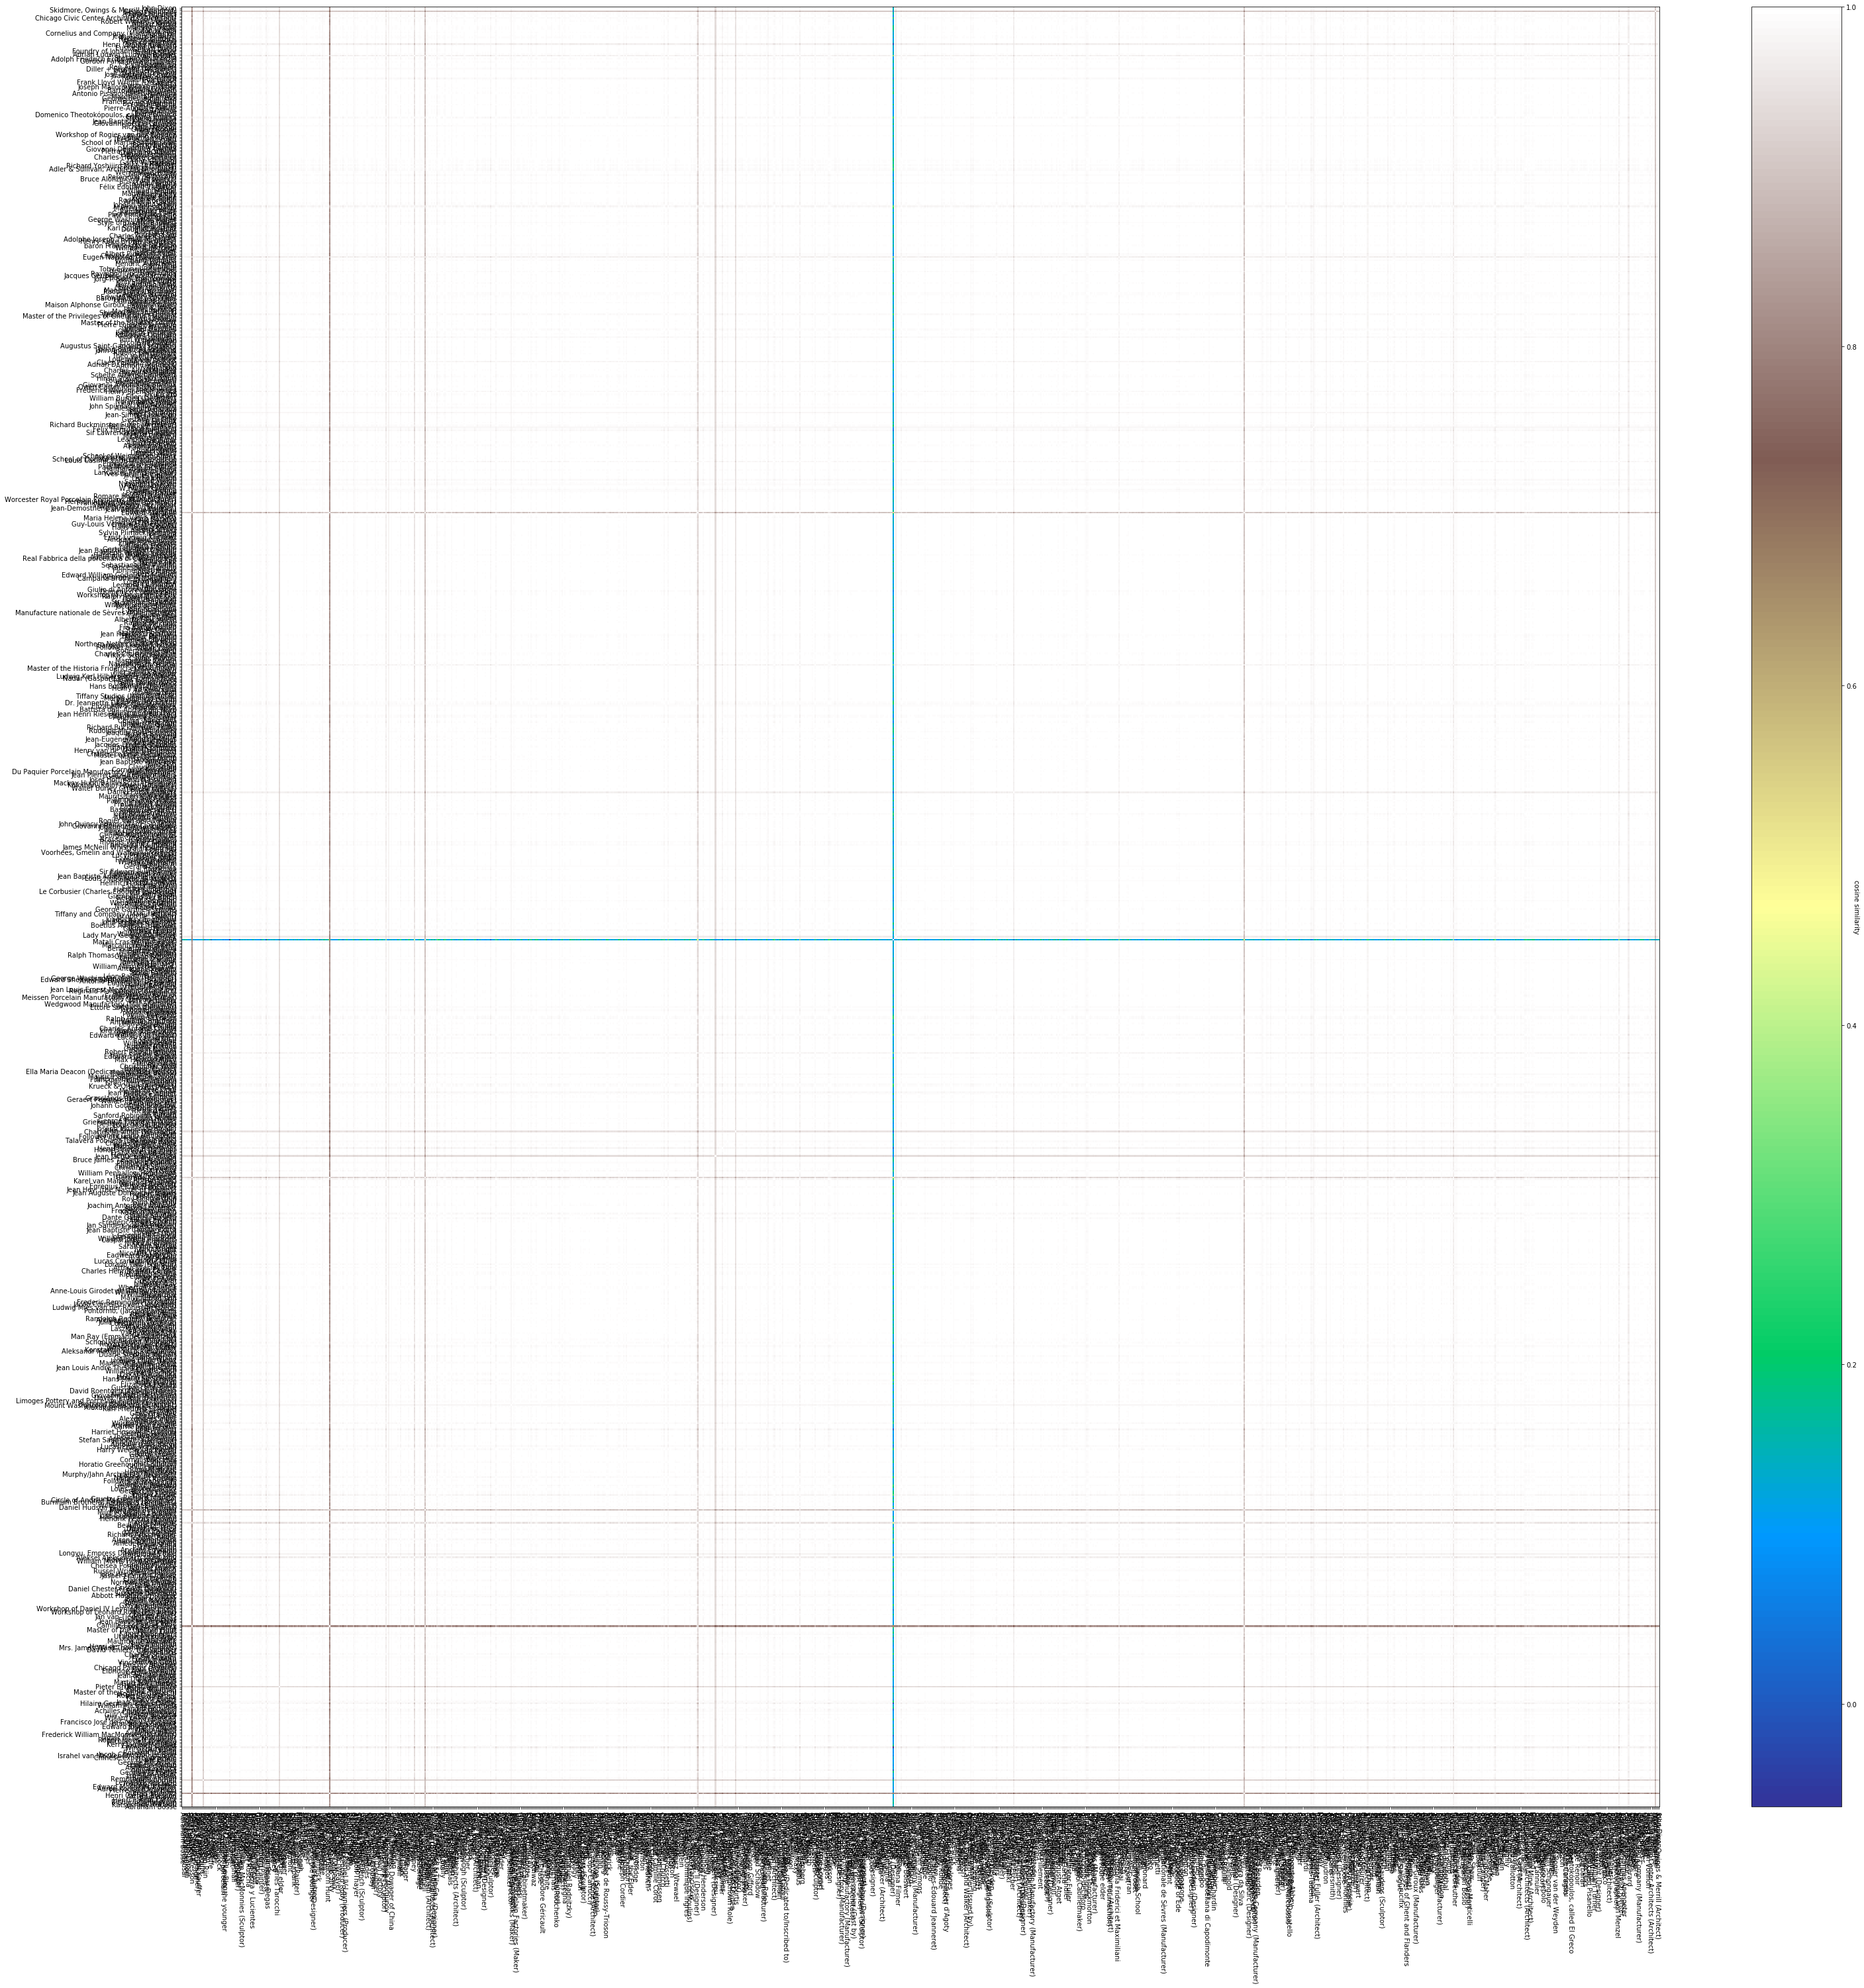

In [64]:
# Visualize similarities between artists

targetDocs = [ind for ind in art_chicago_artists.index]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = art_chicago_artists_d2v.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, art_chicago_artists_d2v.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

fig, ax = plt.subplots(figsize=(50, 50))
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

The similarities between most of the pairwise artists are very high up to 1. This is due to the lack of sufficient text in this corpus. Many of the artworks have very limited description text while some of the others have suffient resources. Given the short length of the descriptions, many artworks are described using very similar vocabulary, which merely introduced the basic information about the collections without any further extension. Therefore, the patterns that can be revealed by analyzing this corpus may be limited. However, for those of the artworks that have sufficient text data, this corpus can reveal some useful information. 

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [47]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [48]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [49]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

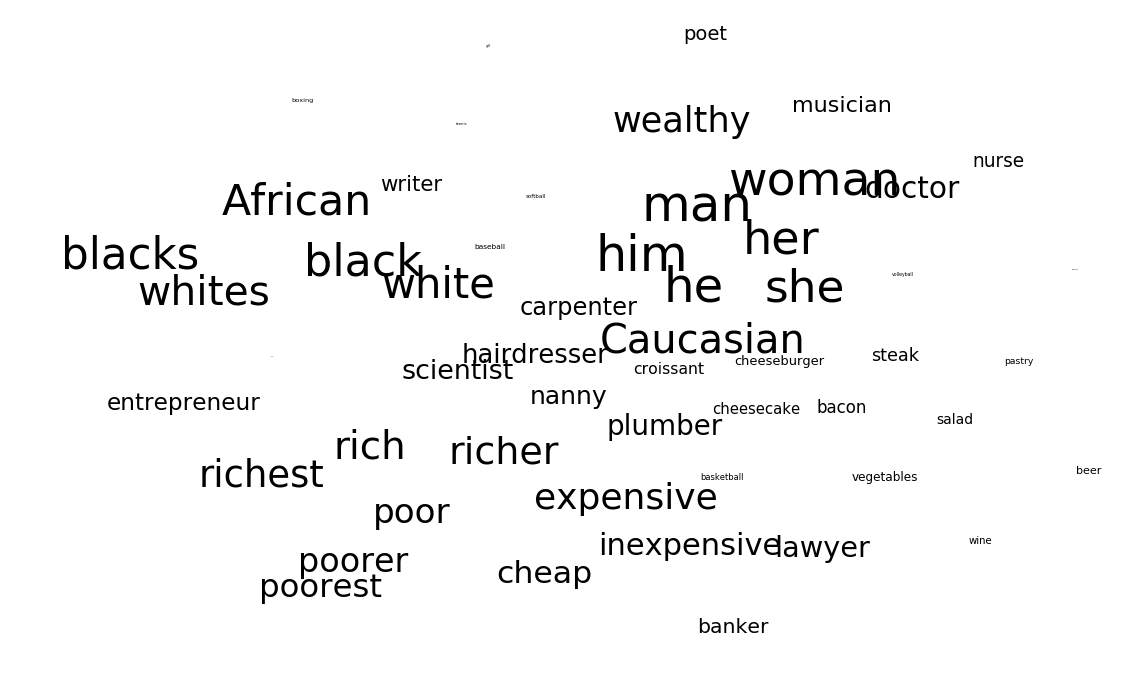

In [50]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [51]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [52]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [53]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [54]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [55]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [56]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

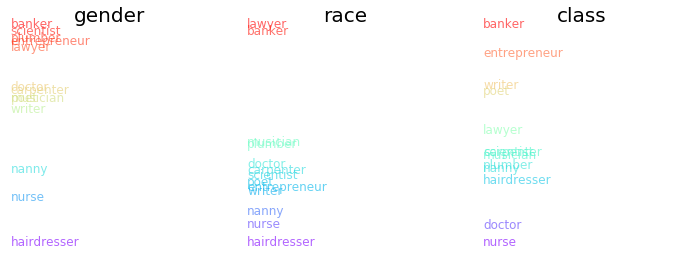

In [57]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

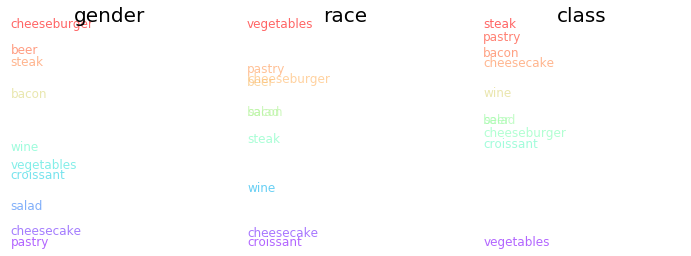

In [58]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

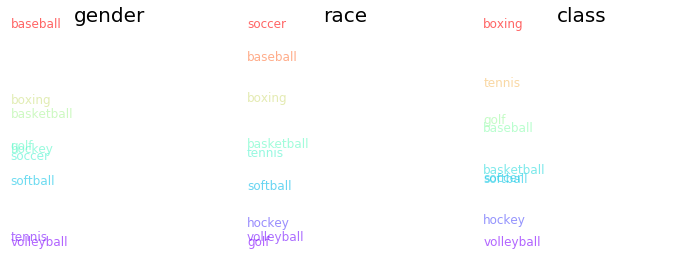

In [59]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [126]:
len(art_chicago_w2v['scenery'])
# art_chicago_artists_d2v

100

In [121]:
#words to create dimensions
art_chicago_TargetWords = ['real', 'representational', 'figurative', 'objective', 
                           'abstract', 'romantic', 'feeling', 'thought']
#words we will be mapping
art_chicago_TargetWords += ['realism', 'cubism', 'surrealism', 'stijl', 'romanticism', 'impressionism', 'expressionism', 'bauhaus']


wordsSubMatrix = []
for word in art_chicago_TargetWords:
    wordsSubMatrix.append(art_chicago_w2v[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix.shape

(16, 100)

In [122]:
# dimension reduction to visualize
# pcaWords_art_chicago_dimension = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
# reducedPCA_art_chicago_dimension = pcaWords_art_chicago_dimension.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords_art_chicago_dimension = sklearn.manifold.TSNE(n_components = 2).fit_transform(wordsSubMatrix)

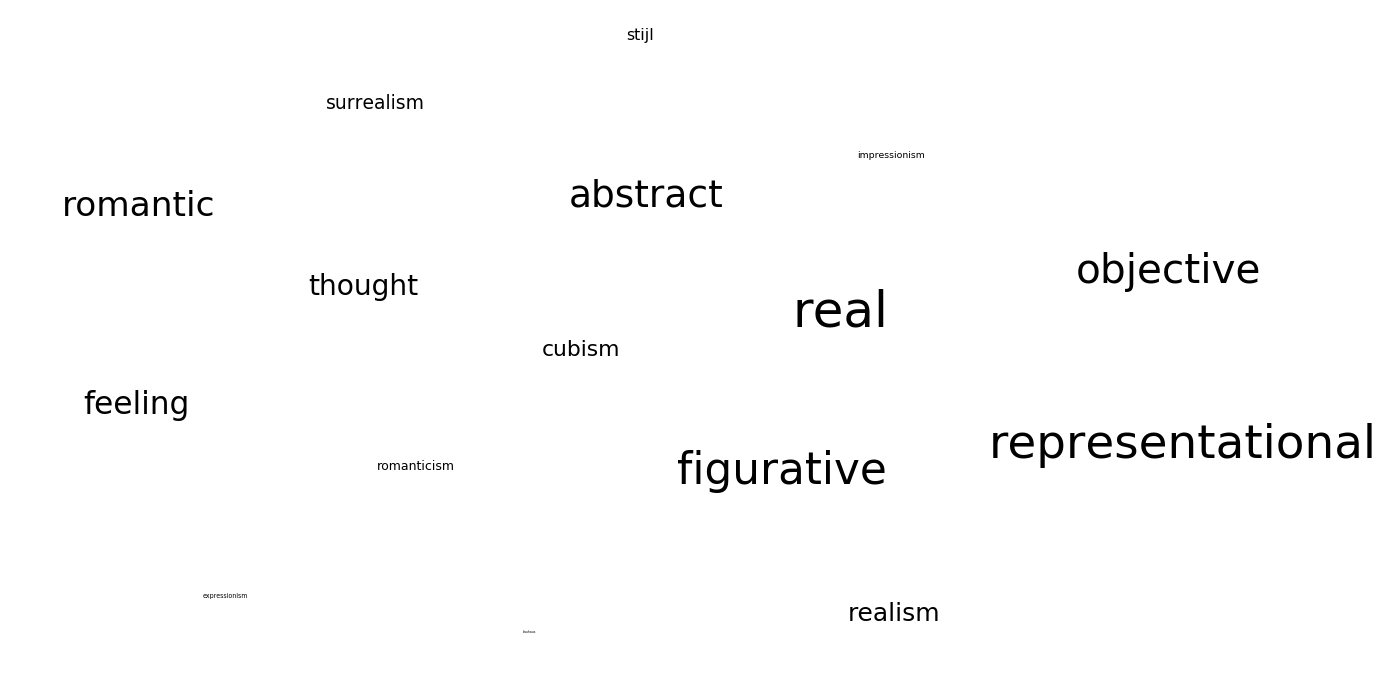

In [123]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords_art_chicago_dimension[:, 0], tsneWords_art_chicago_dimension[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(art_chicago_TargetWords):
    ax.annotate(word, (tsneWords_art_chicago_dimension[:, 0][i],tsneWords_art_chicago_dimension[:, 1][i]), size =  50 * (len(tsneWords_art_chicago_dimension) - i) / len(tsneWords_art_chicago_dimension))
plt.xticks(())
plt.yticks(())
plt.show()

In [124]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [127]:
style = dimension(art_chicago_w2v, ['real', 'representational', 'scenery', 'object'], 
                                   ['abstract', 'romantic', 'feeling', 'thought'])

In [185]:
school = ['realism', 'cubism', 'surrealism', 'romanticism', 'impressionism', 'expressionism', 'baroque']

In [186]:
def makeDF(model, word_list):
    s = []
    for word in word_list:
        s.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), style.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'style': s}, index = word_list)
    return df

In [187]:
school_df = makeDF(art_chicago_w2v, school) 

In [188]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

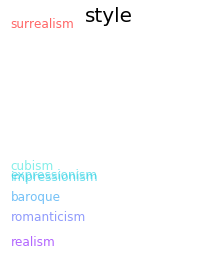

In [189]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, school_df, 'style')
# ax2 = fig.add_subplot(132)
# PlotDimension(ax2, OCCdf, 'race')
# ax3 = fig.add_subplot(133)
# PlotDimension(ax3, OCCdf, 'class')
plt.show()

In [176]:
# project artists onto the axis of style 
artists = art_chicago_artists.index

# Only project those artists who has 3 or more than 3 paragraphs of descripitions
artists_target = []
for artist in artists: 
    if len(art_chicago_artists.loc[artist]['description'].split('\n')) >= 3: 
        artists_target.append(artist)

In [177]:
def makeDF(model, word_list):
    s = []
    for word in word_list:
        s.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), style.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'style': s}, index = word_list)
    return df

In [178]:
artists_df = makeDF(art_chicago_artists_d2v, artists_target) 

In [182]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 10)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

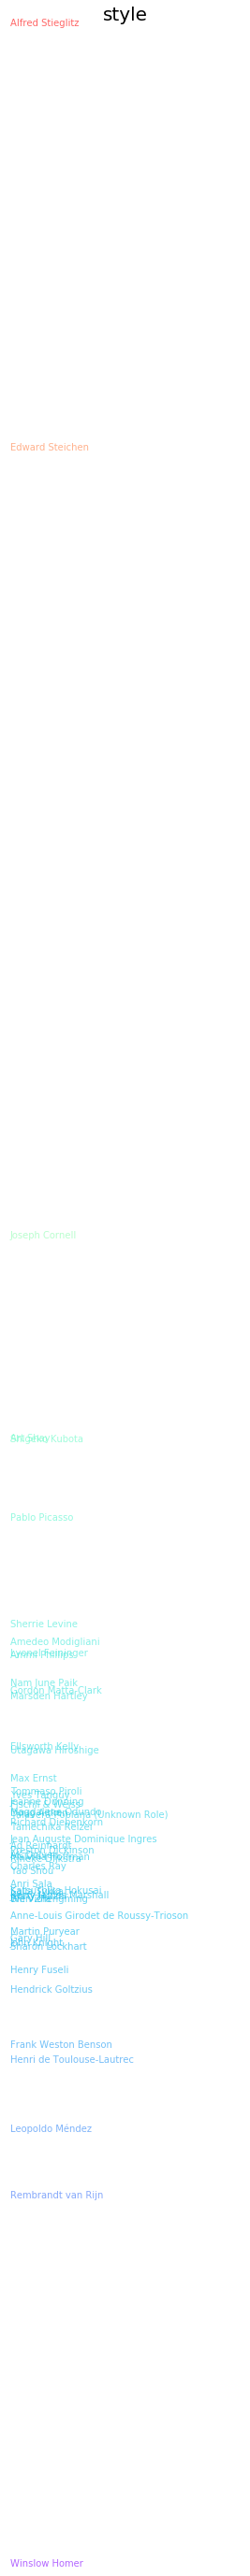

In [184]:
fig = plt.figure(figsize = (15,50))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, artists_df, 'style')
# ax2 = fig.add_subplot(132)
# PlotDimension(ax2, OCCdf, 'race')
# ax3 = fig.add_subplot(133)
# PlotDimension(ax3, OCCdf, 'class')
plt.show()

Here I project art schools as well as artists onto an axis of art style, from figurative to abstract. As we may see from the result, the projection of art schools seems reasonable, with "realism" laying on one end of the axis and "surrealism" laying on the other end. The projection of artists is also satisfying. Winslow Homer is indicated to be the most "realism" artists in this subset. Indeed, he is a representative of the "realism" movement. As is introduced by Wikipedia, "His realism was objective, true to nature, and emotionally controlled". Many other artists also lay in reasonable positions on this axis. 

This shows that the label texts of the artworks do incorporate descriptions of the characteristics of the works related to their style or positions in the art history. And content analysis can reveal this pattern robustly, and it can be argubly used to evaluate the position of other artworks or artists who have not been identified as a certain school. 

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [60]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [61]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [62]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

Unnamed: 0 hiringOrganization_organizationName  \
0       158844       Golfsmith International, Inc.   
1       257645                               Intel   
2       107875                    Florida Hospital   
3       202394                Hitachi Data Systems   
4       109675           Footprint Retail Services   
5       215973                          Home Depot   
6       207524                          Home Depot   
7        64426                      East West Bank   
8       245192                                 IBM   
9       202429                Hitachi Data Systems   
10      269503             J&J Family of Companies   
11      139164                  Genesis Healthcare   
12      255915                      Ingersoll Rand   
13      173294         HamiltonConstructionCompany   
14      116855                      G6 Hospitality   
15       40701                         Dollar Tree   
16      292406              Johns Hopkins Medicine   
17      358904                           LHC Group   
18      126507                                  GE   
19       90538                                  EY   
20       59256             Dr Pepper Snapple Group   
21       85716     Eurofins Lancaster Laboratories   
22      203342                             HMSHOST   
23      283327                          Jewel-Osco   
24      320876       KeyPoint Government Solutions   
25      311069                      Kelly Services   
26      141835              Genesis Rehabilitation   
27      202406                Hitachi Data Systems   
28      111597     Franciscan St. Eilzabeth Health   
29      260448                               Intel   
..         ...                                 ...   
70      197429                            Hill-Rom   
71      359233                           LHC Group   
72        5520                     DCS Corporation   
73      205825                          Home Depot   
74       68546    Education Corporation of America   
75      141067              Genesis Rehabilitation   
76       26925        Destination Hotels & Resorts   
77       81637                Epic Health Services   
78      191317  Hewlett Packard Enterprise Company   
79      134395                  Genesis Healthcare   
80      177803                  Harris Corporation   
81      222835                          Home Depot   
82       12790                            Deloitte   
83      319987            Kettering Medical Center   
84      352211                 Learning Care Group   
85      233278                              Humana   
86      338881                 Kronos Incorporated   
87       53773                       Dominos Pizza   
88      158203                       Golden Living   
89      156994                       Golden Living   
90      249542                   ICF International   
91      173219                     Hallmark Health   
92       50969                       Dominos Pizza   
93      331404                              Kforce   
94      322250                              Kforce   
95      157791                       Golden Living   
96      119835                            GameStop   
97      285609                          Jewel-Osco   
98       89260                     Express Scripts   
99      280096                            JCPenney   

                                       jobDescription  \
0   "Sales Associate Tracking Code 220425-971 Job ...   
1   For PHY system engineering team within the Wir...   
2   *RN Medical Oncology PCU Orlando - Nights* Flo...   
3   Title: Specialist Sales Account Representative...   
4   **Footprint Retail Services** **Job Descriptio...   
5   Position Purpose: Provide outstanding service ...   
6   The Asset Protection Specialist is primarily r...   
7   # Job Description East West Bank is one of the...   
8   Job Description IBM is seeking to hire a Senio...   
9   Title: Field Solutions Engineer Location: New ...   
10  Project Manager (m/w) - 

Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [63]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [64]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [65]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Project Engineering including below jobs: 1. Hardware designing of DCS 2. Software configurations, programming, testing of DCS/PLC 3. Testing and FAT 4. Installation and commissioning. 5. Material ordering, approvals of datasheets. 6. HSE compliance as per HSE directives of HON. BE / B. Tech - Instrumentation / Control / Electronics. **Job:** **Engineering* **Title:** *Systems Engineer* **Location:** *IND-MH-Pune* **Requisition ID:** *00302235*


Like talking on the phone? Enjoy giving great customer service? Use those skills while working flexible,part time hours.


*# Positions:* 2 *Location:* US - UT - Orem *Category:* Engineering


Title: Respiratory Therapy, Intern Location: XX-XX-XX


Title: Position Opening at Illinois Wesleyan University Location: US-IL-Bloomington




Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [66]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

Title: Contract Svc Admin Location: United States\-Michigan\-Caledonia Other Locations: JOB SUMMARY: ESSENTIAL DUTIES AND RESPONSIBILITIES: _ Other duties may be assigned:_ Prepare GPO rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that GPOs are paid accurately and timely Prepare Sales Tracing data for upload into STARR system oEnsure accurate data loads oProcess data into required reports Prepare Rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that distributors are accurately taking rebates against open invoices Manage work flow throughout the sales contracting process Ensure compliance with contract policies and performance requirements Assist in the preparation of charts and sales reports and analytics for customers and Management oQuarterly Reports oSales Tracing Answers customers and internal sale/customer service staff questions regarding pricing Mana

We can do the same for phrases corresponding to job skills.

In [67]:
adprob([["python", "programming"]], resume_model)

-14.355247

In [68]:
adprob([["julia", "programming"]], resume_model)

-33.427353

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [69]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

likelihood
hiringOrganization_organizationName             
Honeywell                             -25.974749
Legrand North America                 -40.500500
Franciscan St. Eilzabeth Health       -43.167206
Illinois Wesleyan University          -52.681591
Gold's Gym                            -75.230896
Jewel-Osco                            -80.965462
Ingersoll Rand                        -81.494949
Kaiser Permanente                     -85.523113
Hallmark Health                       -86.037094
Dr Pepper Snapple Group               -99.421326
General Dynamics Mission Systems     -101.916016
Emory Healthcare                     -102.271820
Genesis Rehabilitation               -105.064774
EY                                   -105.651237
Hewlett Packard Enterprise Company   -106.875103
Dominos Pizza                        -116.374700
Intel                                -117.038742
East West Bank                       -119.060699
DCS Corporation                      -119.501137
Ken Garff                            -120.361084
EMC                                  -121.622444
Eurofins Lancaster Laboratories      -122.223595
Kettering Medical Center             -122.765350
Kronos Incorporated                  -122.840622
HCR ManorCare                        -123.508369
Golfsmith International, Inc.        -123.573792
Kelly Services                       -130.990227
IBM                                  -131.666611
Harris Corporation                   -131.853256
Deutsche Bank                        -132.499237
...                                          ...
Laboratory Corporation of America    -145.438156
Education Corporation of America     -146.955536
KPMG                                 -148.719376
Kelle's Transport Service Inc        -159.437958
Florida Hospital                     -162.604172
Learning Care Group                  -167.503754
J&J Family of Companies              -168.375862
ICF International                    -168.376930
GE                                   -169.097389
Humana                               -172.795746
Footprint Retail Services            -174.338989
Express Scripts                      -177.804581
Deloitte                             -183.557471
Golden Living                        -192.657858
Eaton Corporation                    -209.906540
GPC - Genuine Parts Company          -212.211792
JPMorgan Chase                       -228.657028
Hitachi Data Systems                 -229.553279
Destination Hotels & Resorts         -263.172791
HamiltonConstructionCompany          -324.117249
GameStop                             -328.072083
La Quinta Inns & Suites              -343.545471
Home Depot                           -357.972627
HMSHOST                              -409.498688
LHC Group                            -413.633423
G6 Hospitality                       -468.546722
Epic Health Services                 -527.781067
Kforce                               -762.142422
Dollar Tree                          -818.945801
Hill-Rom                            -2675.631592

[67 rows x 1 columns]

We can also look at the mean likelihood of each state.

In [70]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

likelihood
jobLocation_address_region             
Utah                         -40.500500
Montana                      -63.730721
Connecticut                  -67.623466
Kansas                       -85.259682
Tennessee                    -93.188822
Illinois                     -93.989101
New Hampshire                -94.109772
Georgia                     -102.271820
South Carolina              -103.527328
North Carolina              -108.747134
Ohio                        -122.494473
Louisiana                   -138.063202
Florida                     -147.725601
California                  -147.850291
Maryland                    -151.947347
Arizona                     -154.733734
Minnesota                   -159.437958
Virginia                    -160.932640
Wisconsin                   -170.760437
Missouri                    -177.804581
South Dakota                -180.824776
Nebraska                    -194.792297
Kentucky                    -200.726387
Massachusetts               -205.022661
Oklahoma                    -209.906540
Pennsylvania                -219.999863
New Jersey                  -237.326090
Alabama                     -320.879336
New York                    -328.072083
Indiana                     -328.259613
Texas                       -349.076205
New Mexico                  -447.911438
Oregon                      -453.519656
Michigan                   -1449.594093

You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Exercise 4a*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

The Art Institute of Chicago adopt multiple forms of media to communicate with the audiences. Besides descriptions on the labels, many audiences choose to follow the _audio guide_ offered by the museum to tour around the galleries. Here I sellect a set of samples of the audio scripts, trying to examine the likelihood of the audio scripts are generated from the language model trained by the text corpus. I also find the introduction of the same artwork from Wikipedia, and we will see which is closer to the museum corpus. 

In [56]:
# Load art_chicago_w2v
art_chicago_w2v  = gensim.models.word2vec.Word2Vec.load('art_chicago_word2vec')

In [57]:
vocab = art_chicago_w2v.wv.index2word
len(vocab)

7207

In [58]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

In [64]:
audio_script_sample = pandas.DataFrame({'script': ['In the late nineteenth century the picturesque little towns on the river Seine just west of Paris became popular destinations for Parisians wanting to enjoy a day out. This is one of many paintings made by Renoir at the restaurant Fournaise, which overlooked the river. The two men and a woman sit on one of the restaurant’s river terraces enjoying the summer afternoon after a leisurely lunch. They may all have spent the morning in more active pursuits. The man to the left was a well-known patron of a swimming establishment nearby. His friend to the right is dressed in a rower’s white shirt and pants, and their companion wears a female boater’s blue costume, as does the woman we see through the trellis. Beyond her a racing boat cuts through the water at a faster pace. On the terrace Renoir evokes the atmosphere of relaxation and quietness as the party lingers over wine and fruit. His soft, loose brushwork perfectly conveys the slightly hazy afternoon light. It filters through the trellis to fall glowingly on the men’s white costumes, and the thicker paint application highlights the edges of the wine glasses and decanter with points of dazzling dancing brilliance.', 
                                                   'Paris Street; Rainy Day (French: Rue de Paris, temps de pluie) is a large 1877 oil painting by the French artist Gustave Caillebotte (1848–1894), and is his best known work.[1] It shows a number of individuals walking through the Place de Dublin, then known as the Carrefour de Moscou, at an intersection to the east of the Gare Saint-Lazare in north Paris. Although Caillebotte was a friend and patron of many of the impressionist painters, and this work is part of that school, it differs in its realism and reliance on line rather than broad brush strokes. Caillebotte\'s interest in photography is evident. The figures in the foreground appear \"out of focus\", those in the mid-distance (the carriage and the pedestrians in the intersection) have sharp edges, while the features in the background become progressively indistinct. The severe cropping of some figures – particularly the man to the far right – further suggests the influence of photography. The painting was first shown at the Third Impressionist Exhibition of 1877. It is currently owned by the Art Institute of Chicago.[2] AIC curator Gloria Groom described the work as "the great picture of urban life in the late 19th century."[3]']}, 
                                       index=['museum', 'wikipedia'])

In [65]:
audio_script_sample['tokenized'] = audio_script_sample['script'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
audio_script_sample['normalized'] = audio_script_sample['tokenized'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [66]:
audio_script_sample

script  \
museum     In the late nineteenth century the picturesque...   
wikipedia  Paris Street; Rainy Day (French: Rue de Paris,...   

                                                   tokenized  \
museum     [In, the, late, nineteenth, century, the, pict...   
wikipedia  [Paris, Street, Rainy, Day, French, Rue, de, P...   

                                                  normalized  
museum     [late, 19, century, picturesque, little, town,...  
wikipedia  [paris, street, rainy, day, french, rue, de, p...

In [67]:
audio_script_sample['likelihood'] = audio_script_sample['normalized'].apply(lambda x: adprob(x, art_chicago_w2v))

In [68]:
audio_script_sample['likelihood']

museum      -22.301006
wikipedia   -20.851746
Name: likelihood, dtype: float64

It turns out that the audio scripts offered by the museum itself is, surprisingly, less closer to its own text corpus than Wikipedia is. As we examine the Wikipedia text more carefully, we can observe that the main reference for this artwork is maninly the website of the Art Institute of Chicago. This indicates that the museum actually adopt different style when composing the scripts for audio guide. Indeed, audio and text are designed to offer two different experiences for the audience to tour around the galleries, and audio scripts is expected to make people more comfortable and relaxed while learning about the content that the museum expects to convey. 

Now we try to examine some phrases. 

In [75]:
adprob([['american', 'artist']], art_chicago_w2v)

-11.793395

In [76]:
adprob([['european', 'artist']], art_chicago_w2v)

-13.19735

In [77]:
adprob([['eastern', 'artist']], art_chicago_w2v)

-13.983378

In [78]:
adprob([['african', 'artist']], art_chicago_w2v)

-14.473167

In [79]:
adprob([['greek', 'artist']], art_chicago_w2v)

-13.561682

In [80]:
adprob([['greek', 'artist']], art_chicago_w2v)

-13.561682

In [81]:
adprob([['japanese', 'artist']], art_chicago_w2v)

-12.679498

In [82]:
adprob([['indian', 'artist']], art_chicago_w2v)

-12.893533

In [83]:
adprob([['canadian', 'artist']], art_chicago_w2v)

-16.017658

In [89]:
adprob_result_dict = {}
for word in ['american', 'mexican', 'caribbean', 'latin', 'african', 'european', 'eastern', 'western', 'chinese', 'japanese', 'korean', 'australian', 'canadian', 'british', 'french', 'german', 'italian']: 
    adprob_result_dict[word] = adprob([[word, 'artist']], art_chicago_w2v)

pandas.DataFrame(adprob_result_dict, index=['artist']).transpose()

artist
american   -11.793395
mexican    -13.483535
caribbean   -4.936535
latin      -15.987842
african    -14.473167
european   -13.197350
eastern    -13.983378
western    -12.792584
chinese    -14.375146
japanese   -12.679498
korean     -15.036062
australian  -4.936535
canadian   -16.017658
british    -14.274063
french     -11.663893
german     -13.535764
italian    -12.052324

In [91]:
adprob_result_dict = {}
for word in ['american', 'mexican', 'caribbean', 'latin', 'african', 'european', 'eastern', 'western', 'chinese', 'japanese', 'korean', 'australian', 'canadian', 'british', 'french', 'german', 'italian']: 
    adprob_result_dict[word] = adprob([[word, 'art']], art_chicago_w2v)

pandas.DataFrame(adprob_result_dict, index=['art']).transpose()

art
american   -10.358343
mexican    -13.502272
caribbean   -4.936535
latin      -14.060505
african     -8.665166
european   -11.372192
eastern    -18.718285
western    -10.176641
chinese    -16.677917
japanese   -12.776580
korean     -15.393607
australian  -4.936535
canadian   -16.983015
british    -16.501078
french     -11.425859
german     -16.234556
italian    -11.998274

In [92]:
adprob_result_dict = {}
for word in ['american', 'mexican', 'caribbean', 'latin', 'african', 'european', 'eastern', 'western', 'chinese', 'japanese', 'korean', 'australian', 'canadian', 'british', 'french', 'german', 'italian']: 
    adprob_result_dict[word] = adprob([[word, 'art']], art_chicago_w2v)

pandas.DataFrame(adprob_result_dict, index=['painting']).transpose()

painting
american   -10.358343
mexican    -13.502272
caribbean   -4.936535
latin      -14.060505
african     -8.665166
european   -11.372192
eastern    -18.718285
western    -10.176641
chinese    -16.677917
japanese   -12.776580
korean     -15.393607
australian  -4.936535
canadian   -16.983015
british    -16.501078
french     -11.425859
german     -16.234556
italian    -11.998274

This can reveal the emphasis of the museum when introducing the arts, artists, or paintings of different sources of cultures. Surprisingly, 'caribbean' is significant. This is consistent with the museum's efforts of expanding the presense of American arts. According to the Art Institute of Chicago, "we aim to expand our collections of contemporary Native American and Indigenous art, colonial Latin American art, Caribbean art, and art of the Black Atlantic, among others, in order to offer more representative and inclusive histories of art in this hemisphere."

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [76]:
import copy

In [71]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [72]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [73]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [74]:
def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

Now we generate the models:

In [77]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [78]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

breast


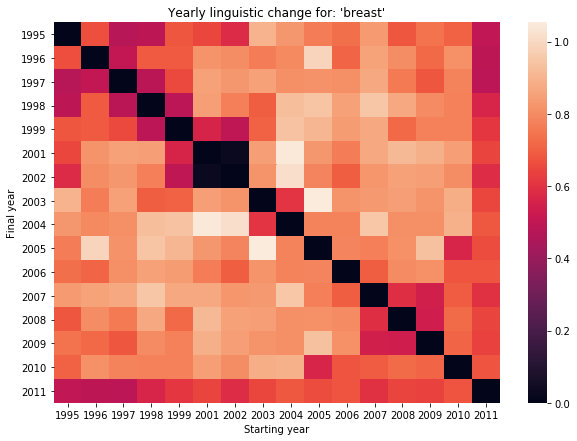

In [79]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

combination


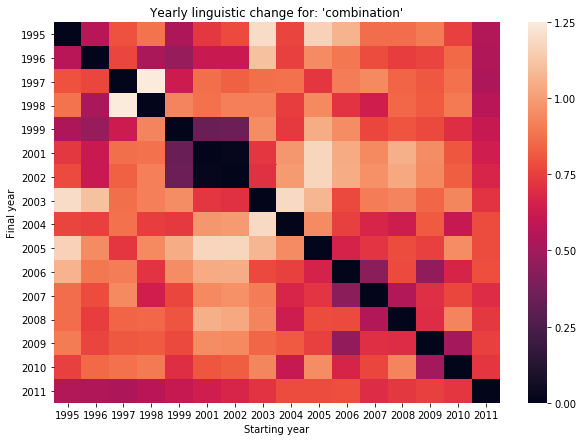

In [80]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [81]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [82]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1571 words to compare


The most divergent words are:

In [83]:
wordDivergences[:20]

[('t', 13.179612953215837),
 ('toxicity', 13.154180981218815),
 ('ml', 13.01737873442471),
 ('+', 12.853400095365942),
 ('activity', 12.749210256617516),
 ('infusion', 12.687976829707623),
 ('paclitaxel', 12.683675490319729),
 ('n', 12.662226218730211),
 ('great', 12.659880327060819),
 ('level', 12.559175675734878),
 ('x', 12.508285094052553),
 ('phase', 12.495868034660816),
 ('cisplatin', 12.456645250320435),
 ('combination', 12.417438723146915),
 ('c', 12.407136777415872),
 ('p', 12.399663124466315),
 ('efficacy', 12.373506214469671),
 ('csf', 12.333098318078555),
 ('show', 12.330282736569643),
 ('iv', 12.321207114960998)]

And the least:

In [84]:
wordDivergences[-20:]

[('answer', 1.7252497673034668),
 ('device', 1.721915602684021),
 ('facilitate', 1.720019280910492),
 ('additionally', 1.685628592967987),
 ('particular', 1.6720524430274963),
 ('ensure', 1.6524746417999268),
 ('context', 1.650183618068695),
 ('definition', 1.6107643842697144),
 ('difficulty', 1.6012009978294373),
 ('discuss', 1.5829300284385681),
 ('call', 1.5171823501586914),
 ('traditional', 1.4596245288848877),
 ('nature', 1.44323068857193),
 ('constitute', 1.4302696585655212),
 ('simple', 1.410505771636963),
 ('practical', 1.3745331764221191),
 ('special', 1.294035017490387),
 ('uncertain', 1.2042807936668396),
 ('situation', 1.1920225620269775),
 ('view', 1.1317378878593445)]

t


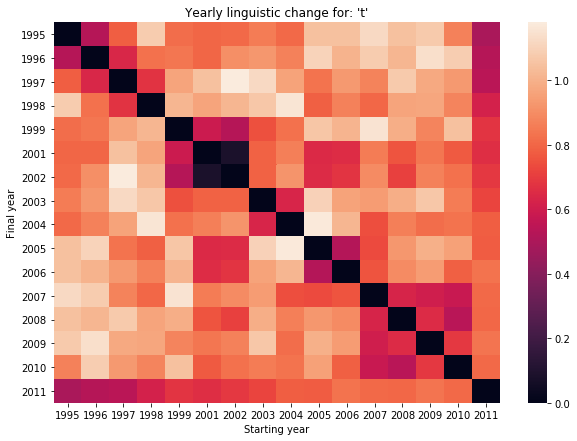

In [85]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

view


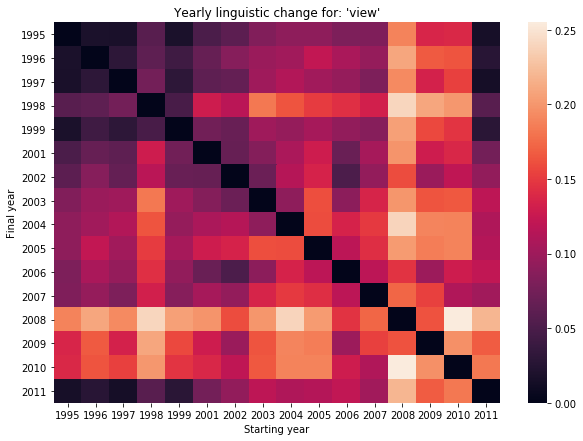

In [86]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## Do the COHA example: Constrast 1800-1819 with 1900-1919 with 2000-2019

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 